## Model 4. Prices Plus Fin. Statements (ppfs) model. Based on LSTM - Long Short Term Memory.

#### PPFS model 4 is the multivariate version of Model 3 PO model. And it is LSTM version of model 2. 
- it has 23 variables. price, volume, returns and the rest are from financial statements dataset.  

Making necessary imports

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# from scipy import stats

Defining the list of companies to predict the stock price for. (Temporarily narrowed down to one stock for testing of the model)

In [67]:
tickers = ['aapl'                                                                                       # stock from Fin. statements dataset
 , 'msft', 'aig', 'pcg', 'mcd', 'bcs', 'nvda', 'intc', 'amzn']                                           # stocks from Fin. statements dataset

Reading csv files with stock price data, converting date to datetime, cleaning from unneeded columns.

In [69]:
stock_dfs = {}
for t in tickers:
    # read csv files
    stock_dfs[t]=pd.read_csv(f'../data/clean_csv/{t}_p_fs.csv')
    # convert date to datetime
    stock_dfs[t]["Date"] = pd.to_datetime(stock_dfs[t]["Date"])
    # Drop irrelevant columns
    stock_dfs[t].drop(columns=['Unnamed: 0', 'OpenInt', 'Open', 'High', 'Low'],inplace=True)
    # Set 'Date' as index
    stock_dfs[t].set_index('Date', inplace=True)
    # Resample to quarterly data and keep the last price in each quarter
    stock_dfs[t] = stock_dfs[t].resample('ME').last()

    # Reset index to make 'Date' a column again
    stock_dfs[t].reset_index(inplace=True)

    print(f'{t}')
    print(stock_dfs[t].shape)

aapl
(98, 24)
msft
(101, 24)
aig
(94, 24)
pcg
(94, 24)
mcd
(94, 24)
bcs
(94, 24)
nvda
(92, 24)
intc
(94, 24)
amzn
(95, 24)


Splitting the data into train and test. Cannot do it without train_test_split function, as it does not maintain the sequence of data, because of it's randomization parameter. 

In [71]:
train_dfs = {}
test_dfs = {}

for t in tickers:
    
    # Train-test split manually
    len_data = len(stock_dfs[t])     #Count of rows that data has
    len_train = round(len_data * 0.75)   # %75 train + %25 test
    len_test = len_data - len_train
   
    print(f'Total rows: {len_data}; Train rows: {len_train}; Test rows: {len_test}.')

    train_dfs[t] = stock_dfs[t][:len_train]
    test_dfs[t] = stock_dfs[t][len_train:]
    # printing to show that train and test dfs do not intersect
    print(t)
    print(train_dfs[t].tail(2))
    print(test_dfs[t].head(2))

Total rows: 98; Train rows: 74; Test rows: 24.
aapl
         Date   Close    Volume  C_returns  Market Cap(in B USD)   Revenue  \
72 2015-10-31  114.56  51494522  -0.008482                586.86  233715.0   
73 2015-11-30  113.90  40696103   0.004321                586.86  233715.0   

    Gross Profit  Net Income  Earning Per Share   EBITDA  ...  Current Ratio  \
72       93626.0     53394.0              2.305  82487.0  ...         1.1088   
73       93626.0     53394.0              2.305  82487.0  ...         1.1088   

    Debt/Equity Ratio      ROE      ROA      ROI  Net Profit Margin  \
72              0.539  44.7355  18.3899  30.9201            22.8458   
73              0.539  44.7355  18.3899  30.9201            22.8458   

    Free Cash Flow per Share  Return on Tangible Equity  Number of Employees  \
72                    0.9743                    48.3878             110000.0   
73                    0.9743                    48.3878             110000.0   

    Inflation Rat

Reshaping the datasets for the model

In [73]:
train_datasets = {}
test_datasets = {}

# Creating datasets and shaping their form for the model.
for t in tickers:
    train_datasets[t] = train_dfs[t][['Close', 'Volume', 'C_returns', 'Market Cap(in B USD)',
       'Revenue', 'Gross Profit', 'Net Income', 'Earning Per Share', 'EBITDA',
       'Share Holder Equity', 'Cash Flow from Operating',
       'Cash Flow from Investing', 'Cash Flow from Financial Activities',
       'Current Ratio', 'Debt/Equity Ratio', 'ROE', 'ROA', 'ROI',
       'Net Profit Margin', 'Free Cash Flow per Share',
       'Return on Tangible Equity', 'Number of Employees',
       'Inflation Rate(in US)']].values
    # train_datasets[t] = np.reshape(train_datasets[t], (-1, 1, train_datasets[t].shape[1]))

    test_datasets[t] = test_dfs[t][['Close', 'Volume', 'C_returns', 'Market Cap(in B USD)',
       'Revenue', 'Gross Profit', 'Net Income', 'Earning Per Share', 'EBITDA',
       'Share Holder Equity', 'Cash Flow from Operating',
       'Cash Flow from Investing', 'Cash Flow from Financial Activities',
       'Current Ratio', 'Debt/Equity Ratio', 'ROE', 'ROA', 'ROI',
       'Net Profit Margin', 'Free Cash Flow per Share',
       'Return on Tangible Equity', 'Number of Employees',
       'Inflation Rate(in US)']].values
    # test_datasets[t] = np.reshape(test_datasets[t], (-1, 1, test_datasets[t].shape[1]))
    print(train_datasets[t].shape)

(74, 23)
(76, 23)
(70, 23)
(70, 23)
(70, 23)
(70, 23)
(69, 23)
(70, 23)
(71, 23)


Scaling train data. Applying lookback window. Reshaping for model.

In [75]:
train_datasets_scaled = {}
scales = {}

X_trains = {}
y_trains = {}

Lookback = 12

for t in tickers:
    # Scaling train Dataset
    scales[t] = MinMaxScaler(feature_range = (0,1))
    train_datasets_scaled[t] = scales[t].fit_transform(train_datasets[t])
    X_trains[t] = []
    y_trains[t] = []
    len_train = len(train_datasets_scaled[t])

    # Creating a moving window of size Lookback for the forecast
    for i in range(Lookback, len_train):
        X_trains[t].append(train_datasets_scaled[t][i - Lookback:i, :])
        y_trains[t].append(train_datasets_scaled[t][i, 0])

    # Converting to Numpy array and reshaping for model
    X_trains[t], y_trains[t] = np.array(X_trains[t]), np.array(y_trains[t])
    X_trains[t] = np.reshape(X_trains[t], (X_trains[t].shape[0], X_trains[t].shape[1],X_trains[t].shape[2]))
    y_trains[t] = np.reshape(y_trains[t], (y_trains[t].shape[0],1))
    print("Shape of X_trains:",X_trains[t].shape)
    print("Shape of y_trains:",y_trains[t].shape)
    

Shape of X_trains: (62, 12, 23)
Shape of y_trains: (62, 1)
Shape of X_trains: (64, 12, 23)
Shape of y_trains: (64, 1)
Shape of X_trains: (58, 12, 23)
Shape of y_trains: (58, 1)
Shape of X_trains: (58, 12, 23)
Shape of y_trains: (58, 1)
Shape of X_trains: (58, 12, 23)
Shape of y_trains: (58, 1)
Shape of X_trains: (58, 12, 23)
Shape of y_trains: (58, 1)
Shape of X_trains: (57, 12, 23)
Shape of y_trains: (57, 1)
Shape of X_trains: (58, 12, 23)
Shape of y_trains: (58, 1)
Shape of X_trains: (59, 12, 23)
Shape of y_trains: (59, 1)


In [76]:
test_datasets_scaled = {}
test_scales = {}

X_tests = {}
y_tests = {}

for t in tickers:
    # Scaling test Dataset
    test_scales[t] = MinMaxScaler(feature_range = (0,1))
    test_datasets_scaled[t] = test_scales[t].fit_transform(test_datasets[t])
    X_tests[t] = []
    y_tests[t] = []
    len_test = len(test_datasets_scaled[t])

    # Creating a moving window of size Lookback for the forecast
    for i in range(Lookback, len_test):
        X_tests[t].append(test_datasets_scaled[t][i - Lookback:i, :])
        y_tests[t].append(test_datasets_scaled[t][i, 0])

    # Converting to Numpy array and reshaping for model
    X_tests[t], y_tests[t] = np.array(X_tests[t]), np.array(y_tests[t])
    X_tests[t] = np.reshape(X_tests[t], (X_tests[t].shape[0], X_tests[t].shape[1],X_tests[t].shape[2]))
    y_tests[t] = np.reshape(y_tests[t], (y_tests[t].shape[0],1))
    print({t})
    print("Shape of X_tests:",X_tests[t].shape)
    print("Shape of y_tests:",y_tests[t].shape)

{'aapl'}
Shape of X_tests: (12, 12, 23)
Shape of y_tests: (12, 1)
{'msft'}
Shape of X_tests: (13, 12, 23)
Shape of y_tests: (13, 1)
{'aig'}
Shape of X_tests: (12, 12, 23)
Shape of y_tests: (12, 1)
{'pcg'}
Shape of X_tests: (12, 12, 23)
Shape of y_tests: (12, 1)
{'mcd'}
Shape of X_tests: (12, 12, 23)
Shape of y_tests: (12, 1)
{'bcs'}
Shape of X_tests: (12, 12, 23)
Shape of y_tests: (12, 1)
{'nvda'}
Shape of X_tests: (11, 12, 23)
Shape of y_tests: (11, 1)
{'intc'}
Shape of X_tests: (12, 12, 23)
Shape of y_tests: (12, 1)
{'amzn'}
Shape of X_tests: (12, 12, 23)
Shape of y_tests: (12, 1)


Building the model itself.

In [78]:
models = {}
histories = {}

for t in tickers:
    # initiate LSTM
    models[t] = Sequential()
    
    # adding first LSTM layer and dropout regulatization
    models[t].add(
        LSTM(units = Lookback, 
                  activation = "tanh", 
                  return_sequences = True, 
                  input_shape = (X_trains[t].shape[1],X_trains[t].shape[2]))
                 )
    
    models[t].add(
        Dropout(0.2)
                 )
    
    
    # adding second and third LSTM layer and dropout regulatization
    
    models[t].add(
        LSTM(units = Lookback, 
                  activation = "tanh", 
                  return_sequences = True)
                 )
    
    models[t].add(
        Dropout(0.2)
                 )

    models[t].add(
        LSTM(units = Lookback, 
                  activation = "tanh", 
                  return_sequences = True)
                 )
    
    models[t].add(
        Dropout(0.2)
                 )
    
    # adding forth LSTM layer and dropout regulatization
    
    models[t].add(
        LSTM(units = Lookback)
                 )
    
    models[t].add(
        Dropout(0.2)
                 )
    
    # adding the output layer
    models[t].add(Dense(units = 1))
    
    # compiling LSTM
    models[t].compile(
        optimizer = "adam", 
        loss = "mean_squared_error",
        metrics = ["accuracy"])
    
    # fitting the LSTM
    histories[t] = models[t].fit(X_trains[t], y_trains[t], epochs = 50, batch_size = 32, verbose=0)

C:\Users\Vladimir\anaconda3\envs\ml_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


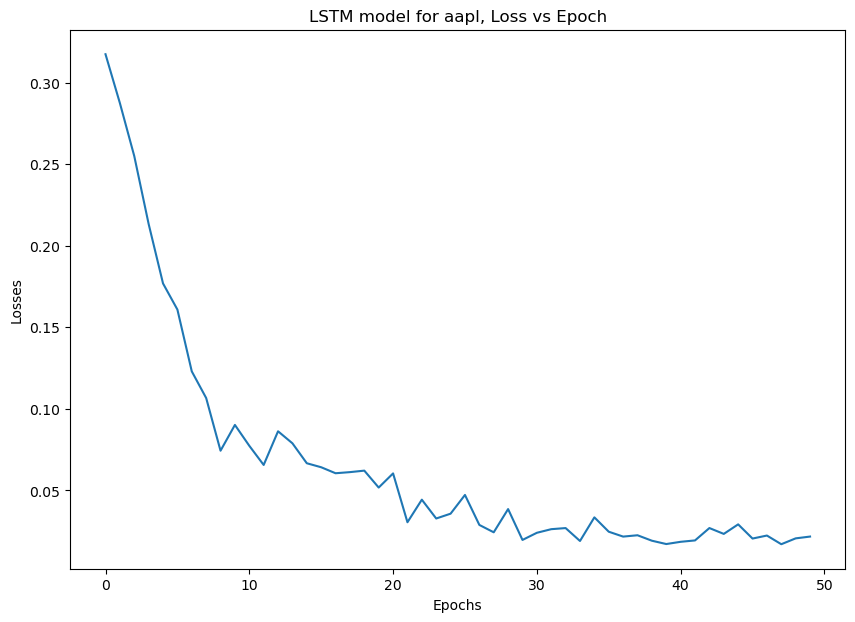

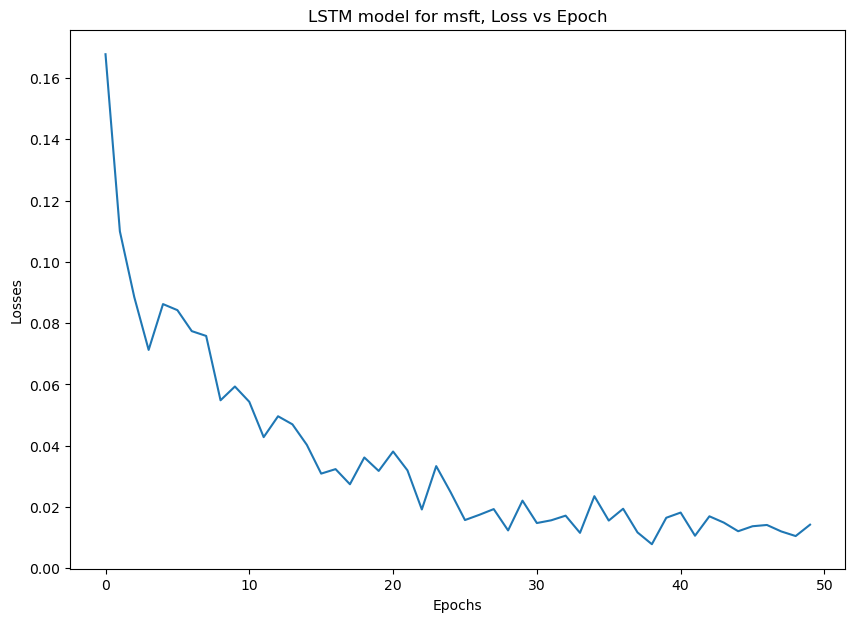

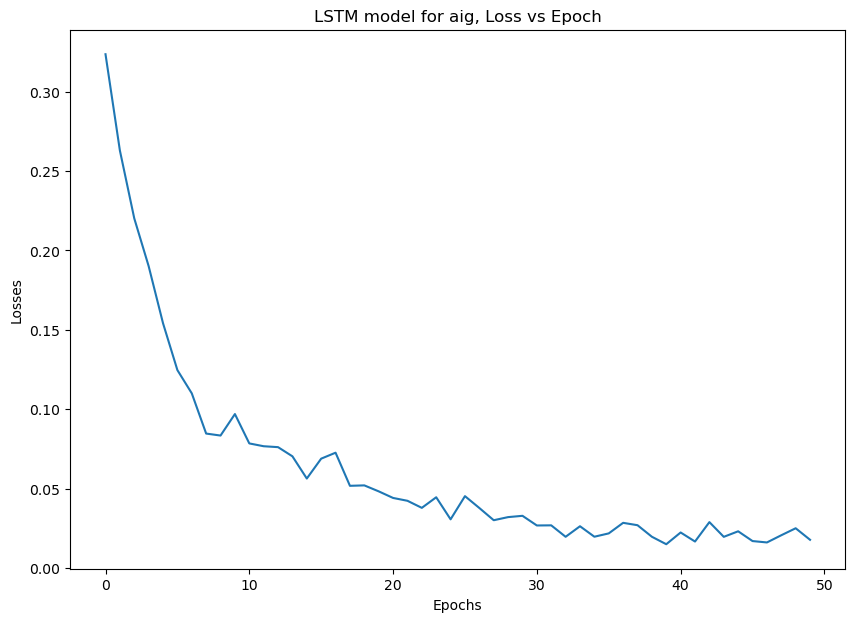

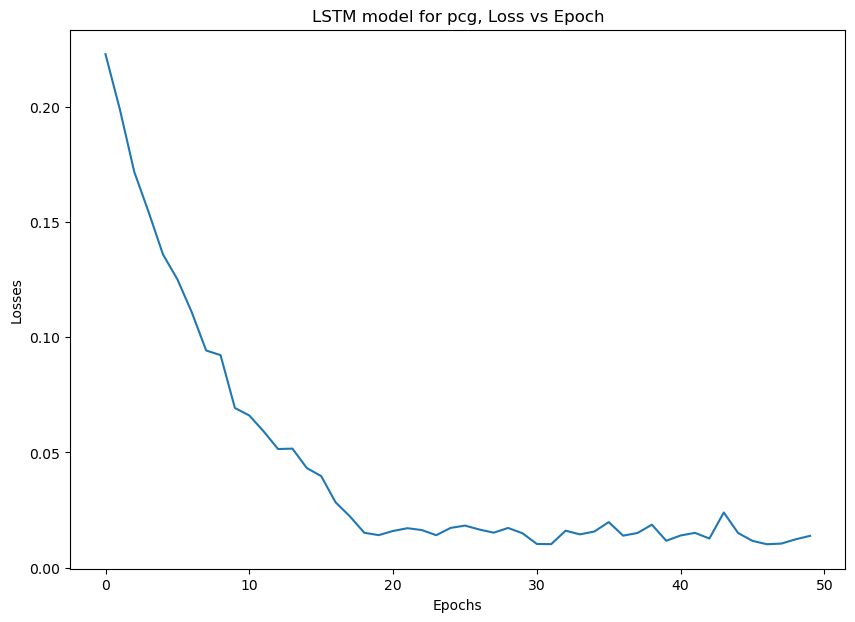

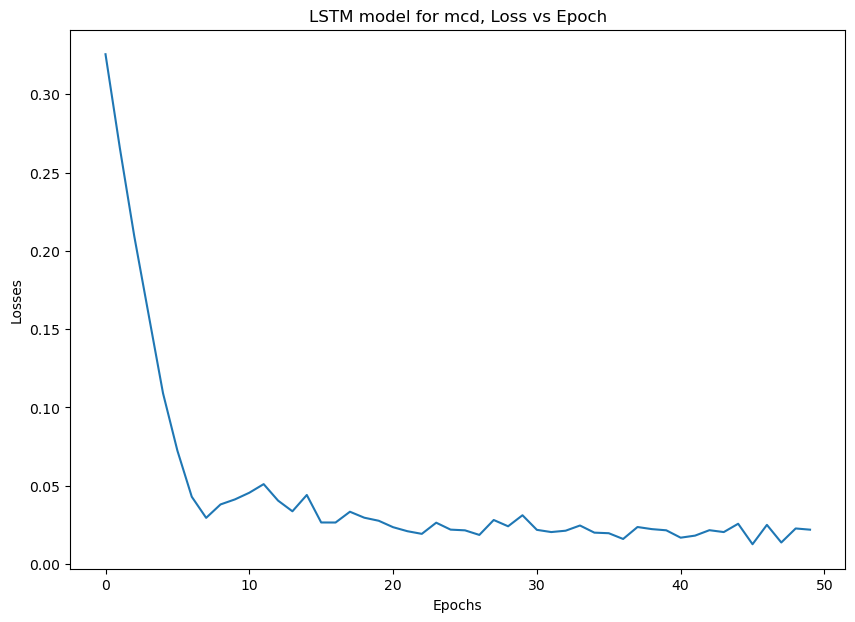

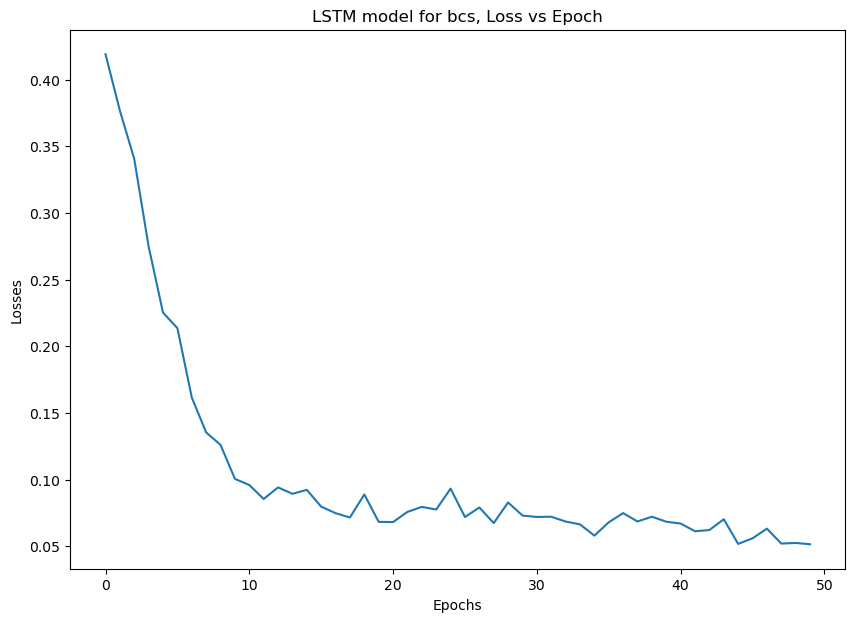

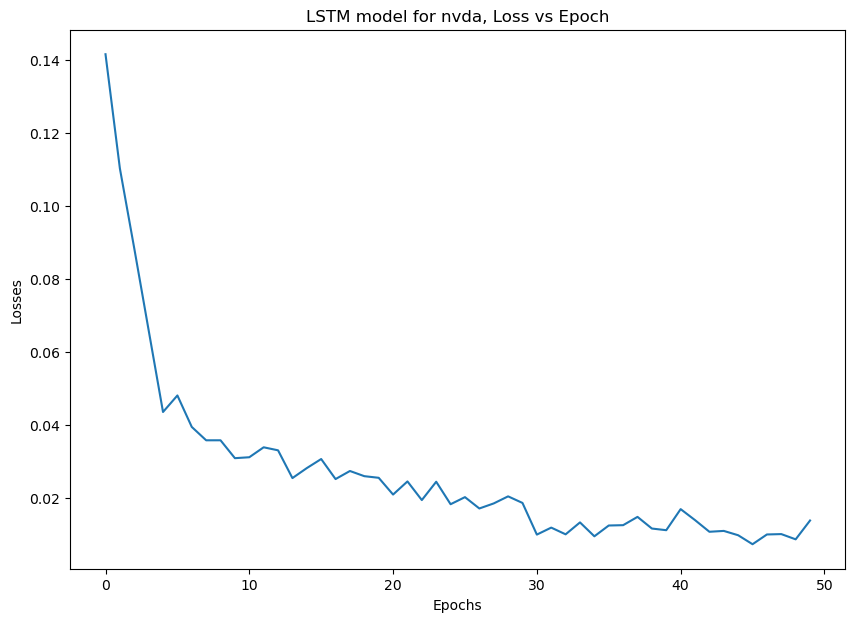

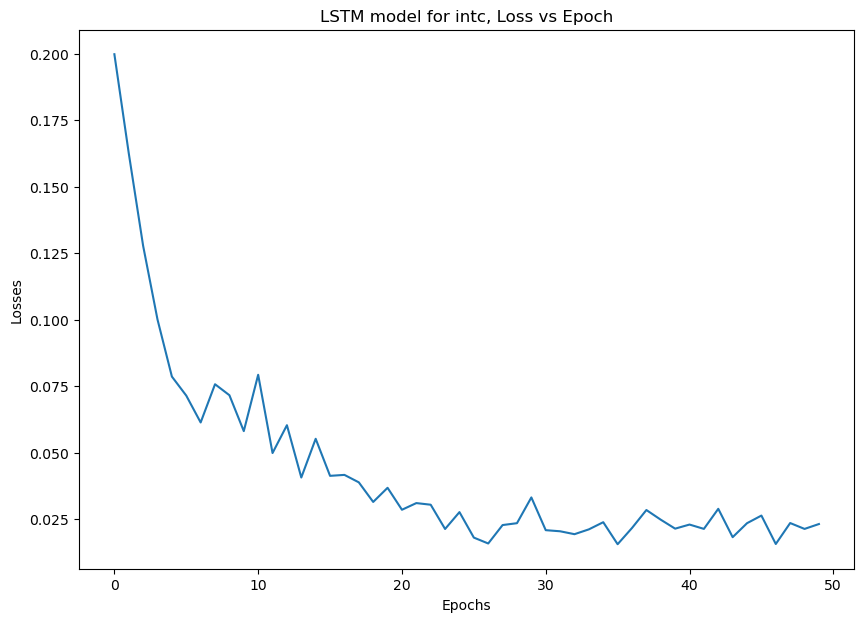

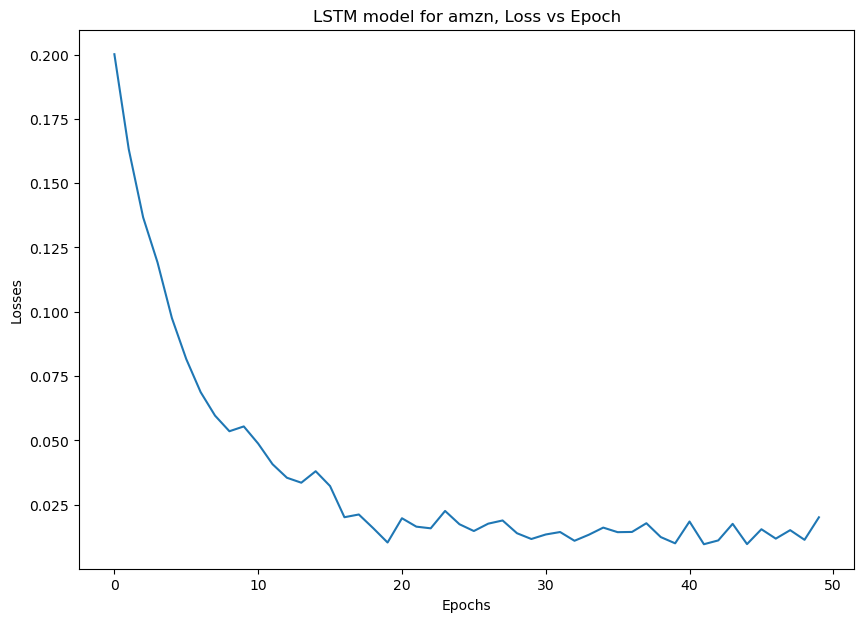

In [79]:
for t in tickers:
    # Plotting Loss vs Epochs
    plt.figure(figsize =(10,7))
    plt.plot(histories[t].history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(f"LSTM model for {t}, Loss vs Epoch")
    plt.show()

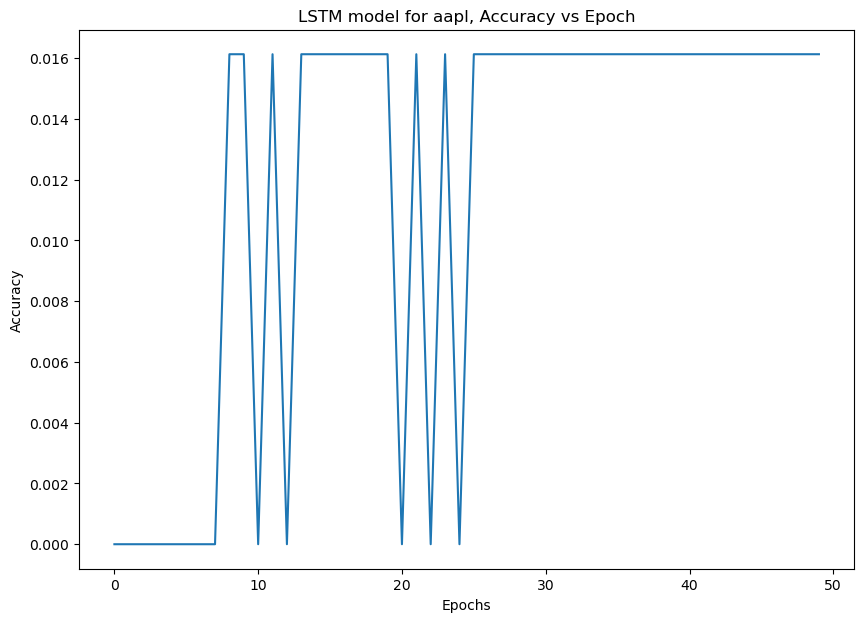

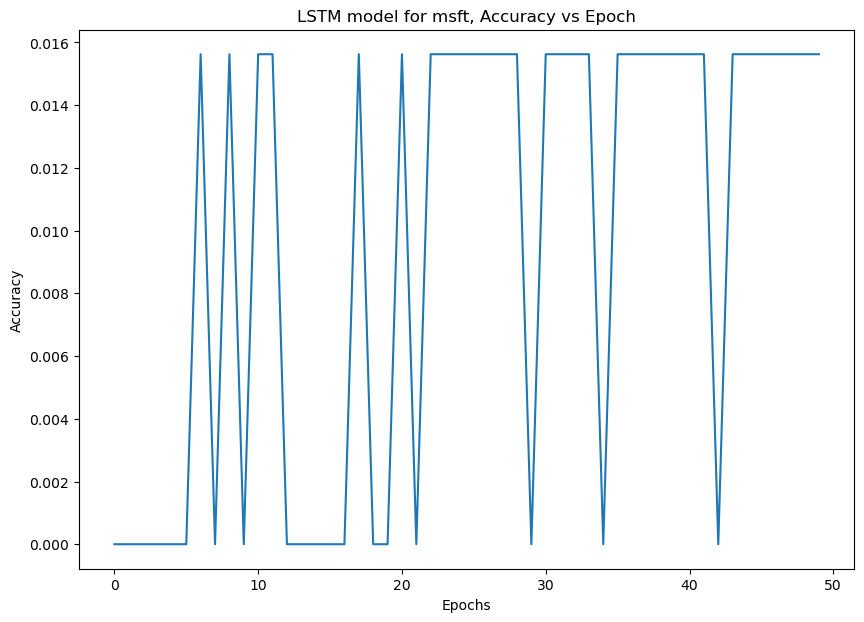

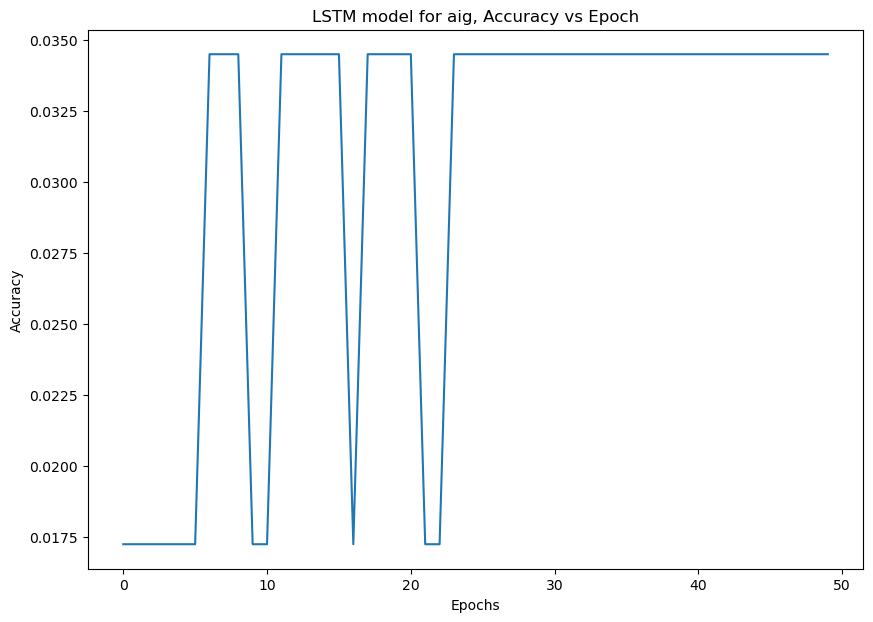

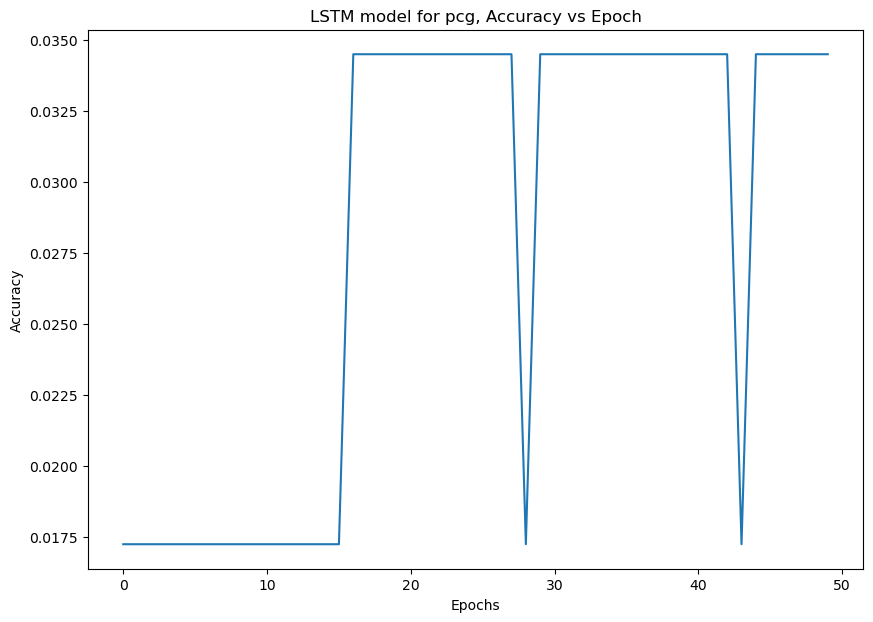

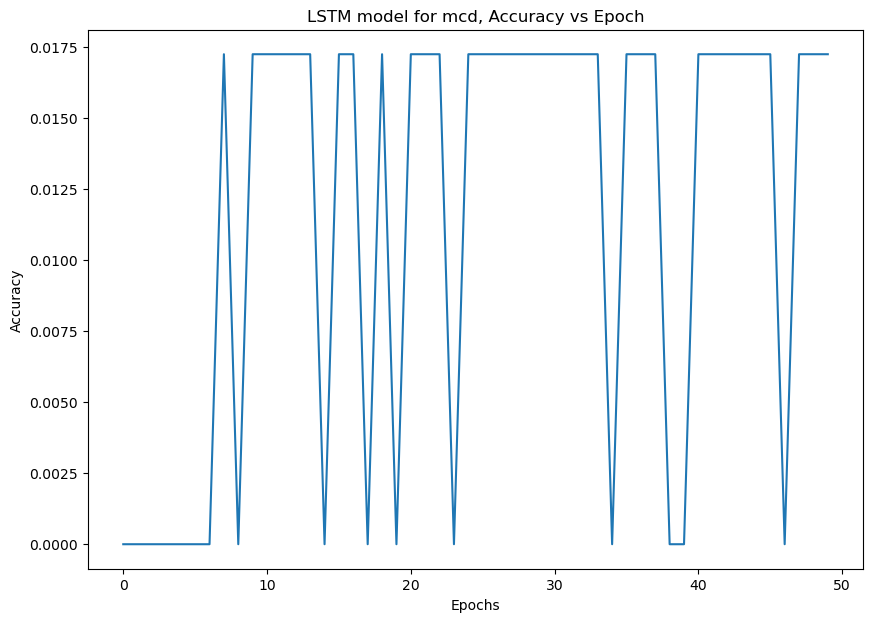

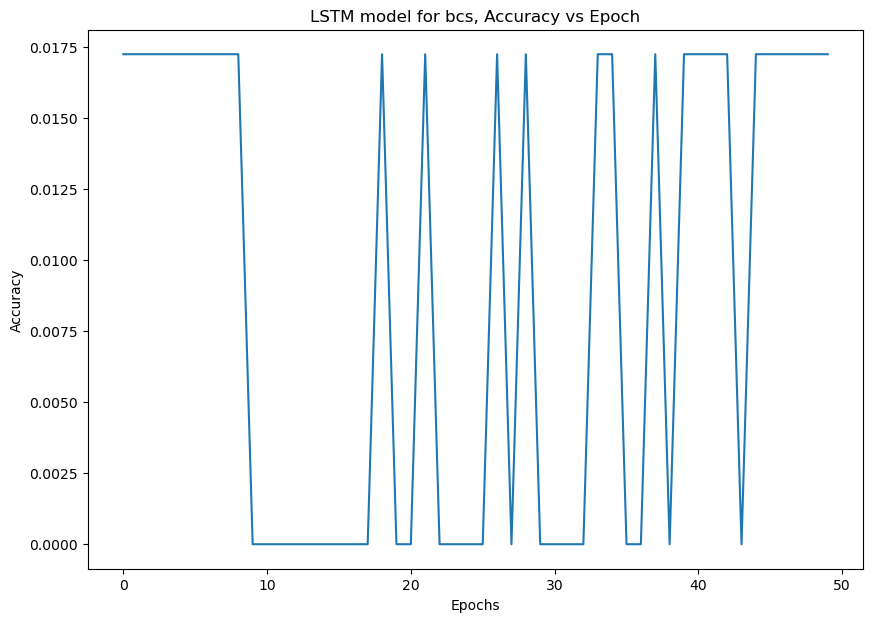

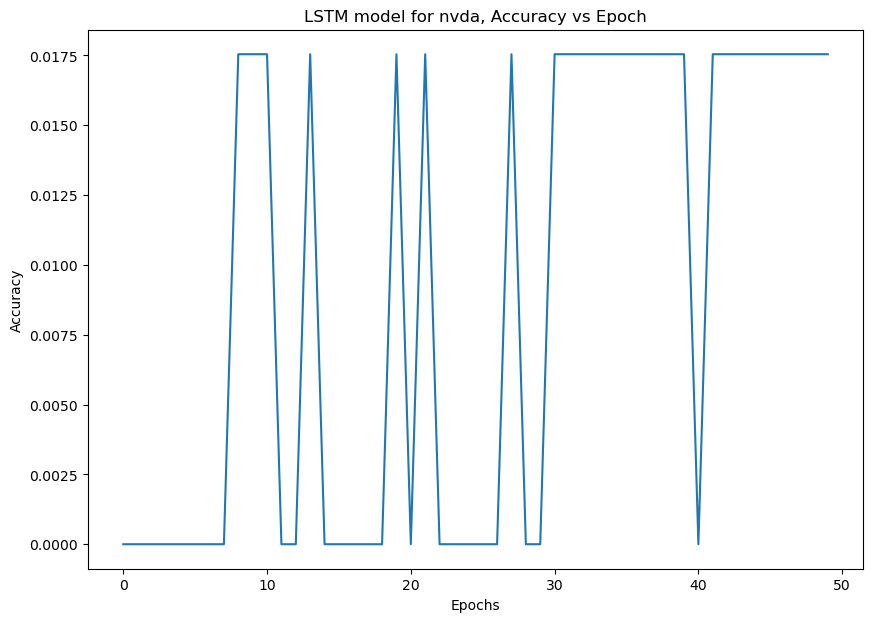

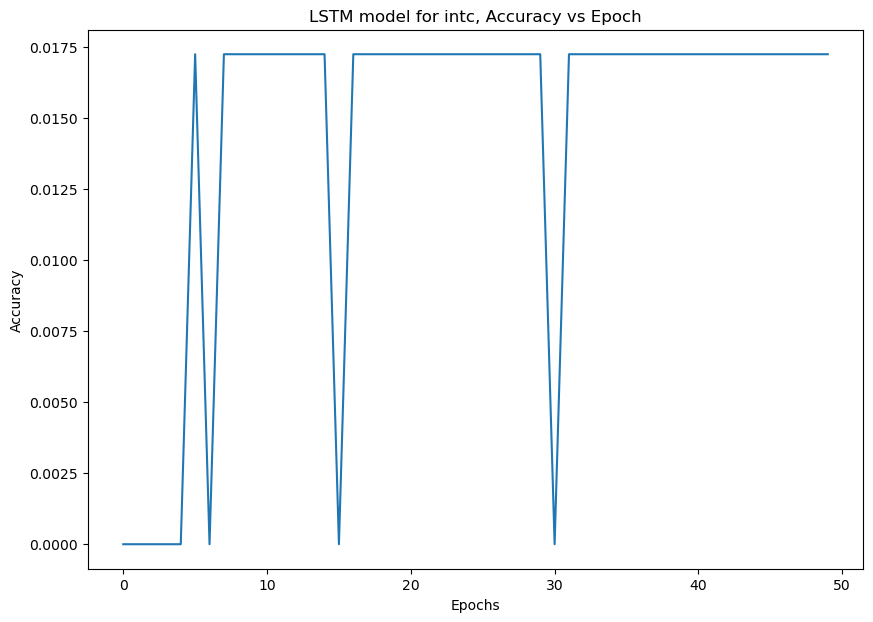

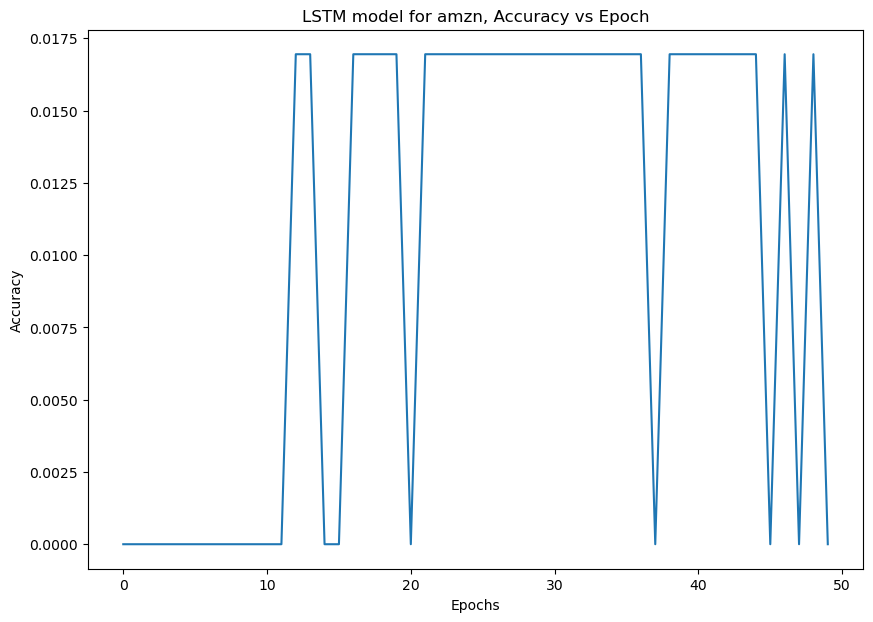

In [80]:
for t in tickers:
    # Plotting Accuracy vs Epochs
    plt.figure(figsize =(10,7))
    plt.plot(histories[t].history["accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"LSTM model for {t}, Accuracy vs Epoch")
    plt.show()

Making train predictions. Visualizing train data and prediction.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


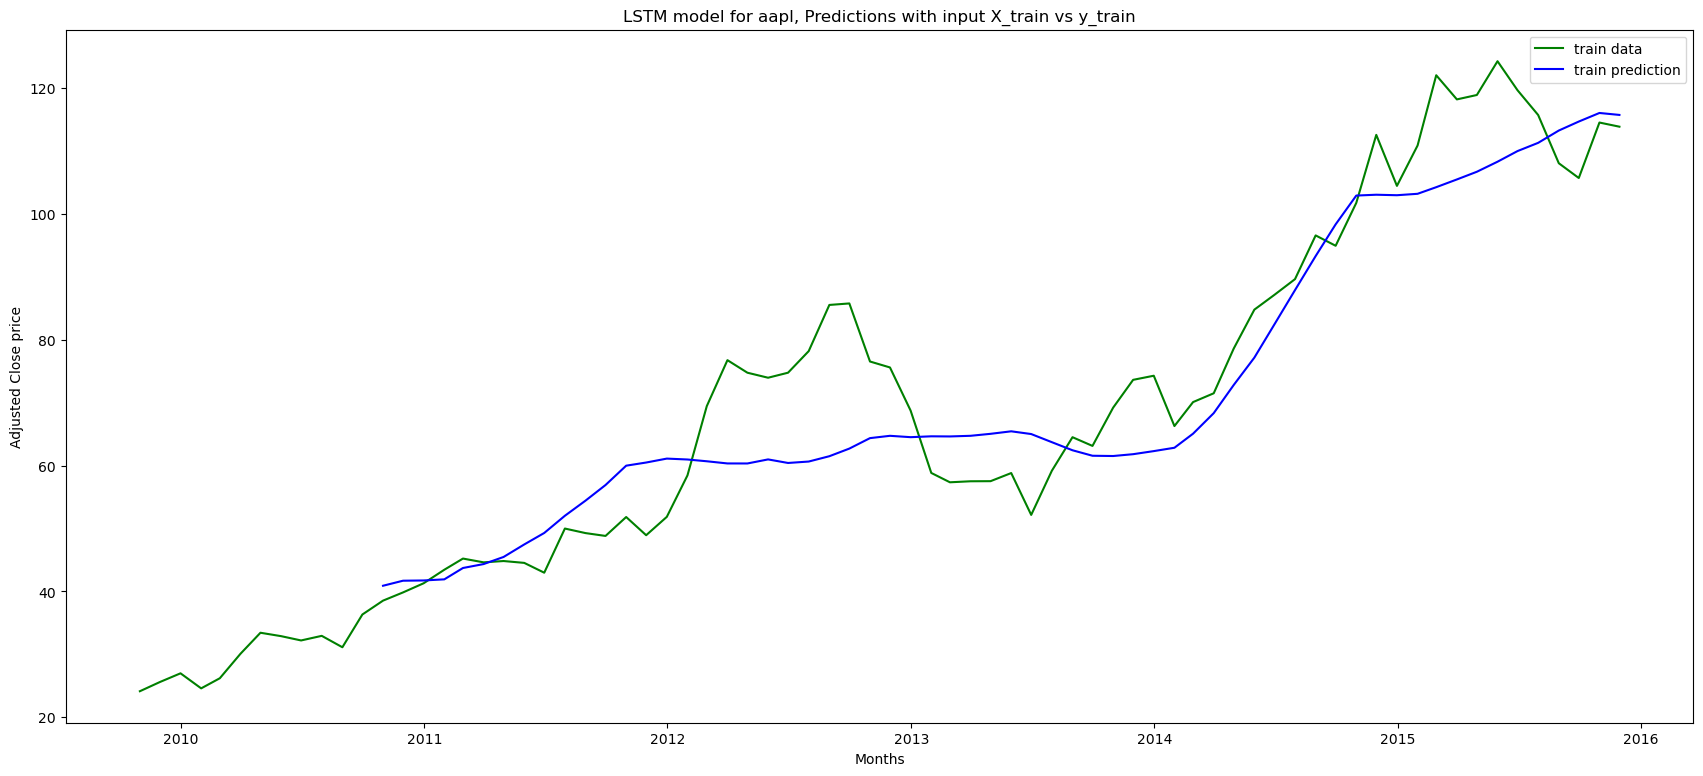

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  


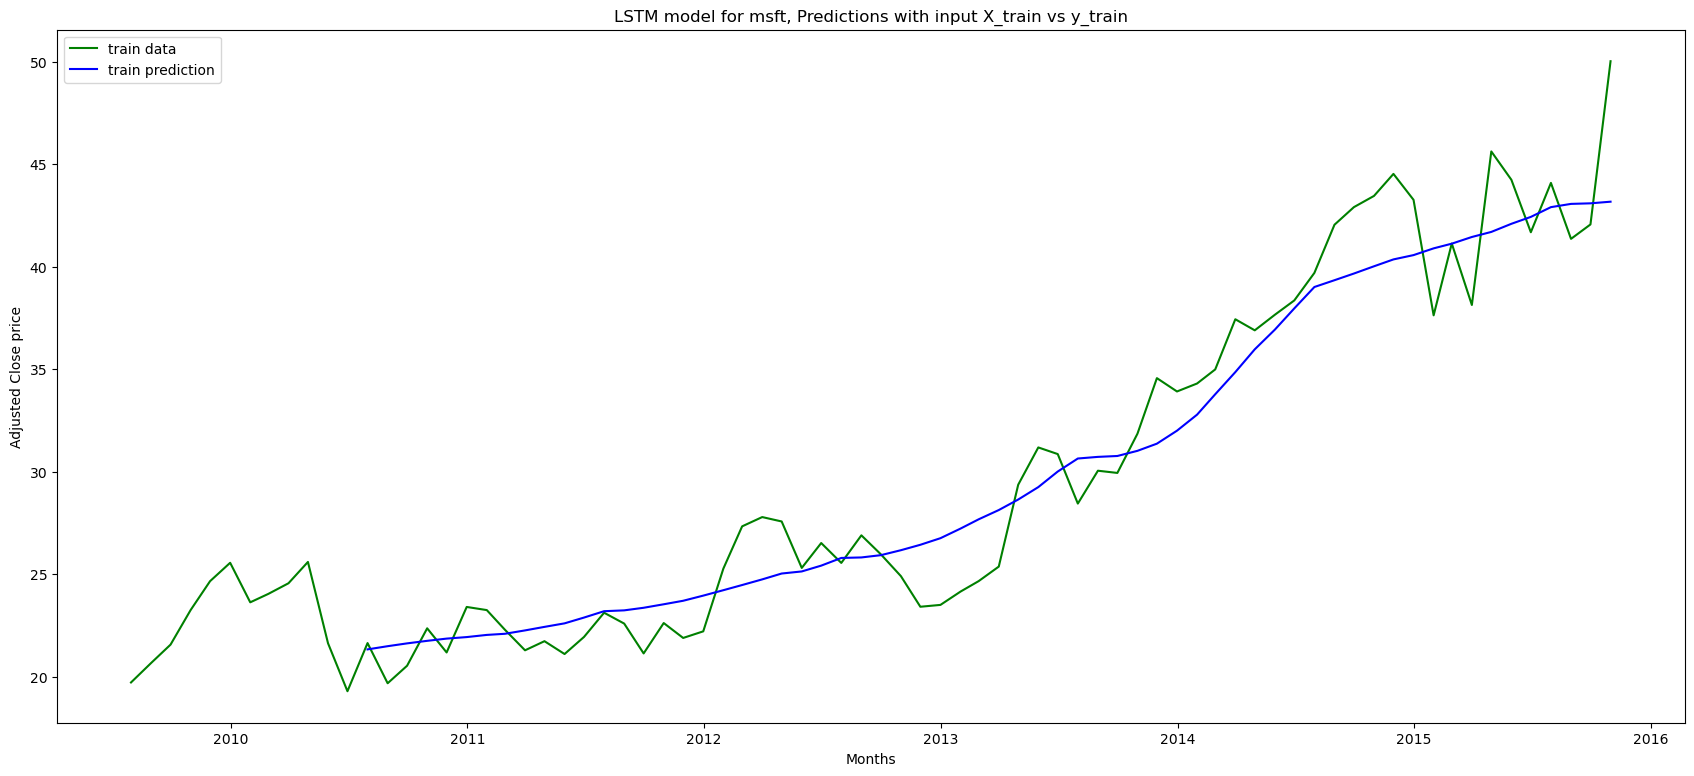

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


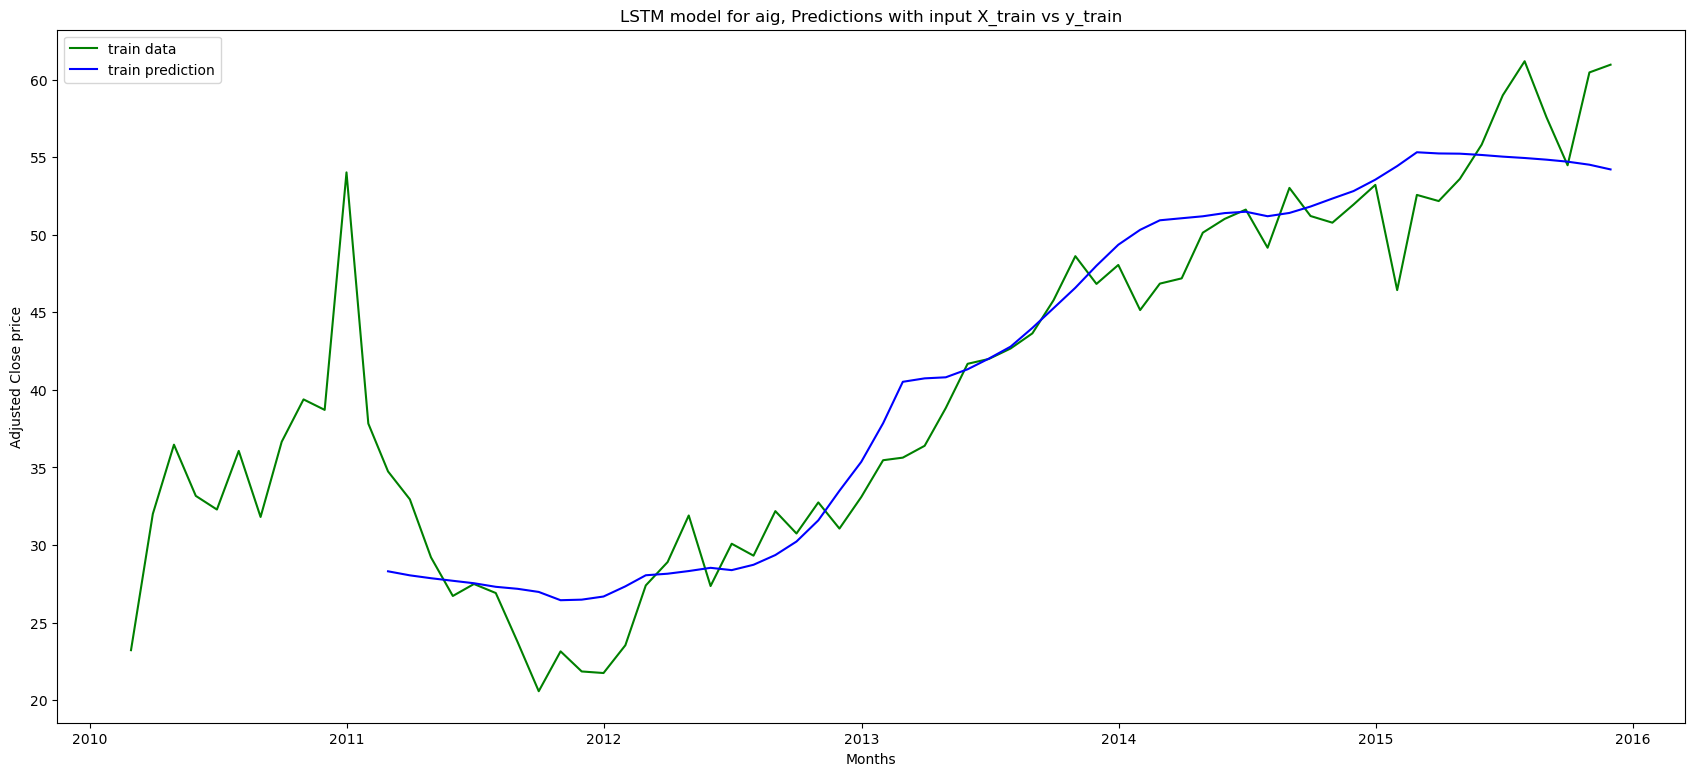

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


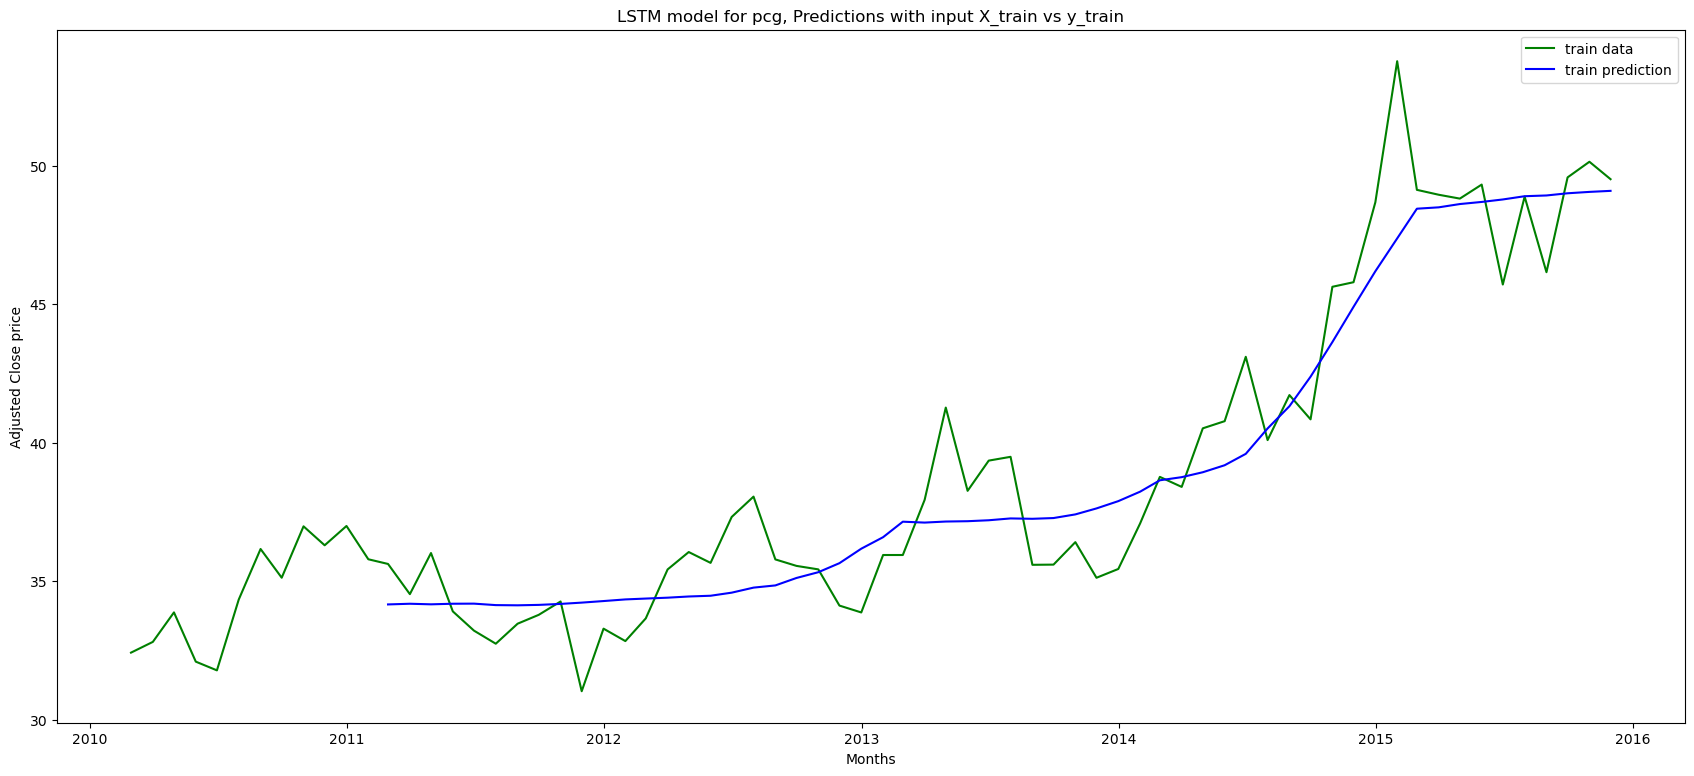

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


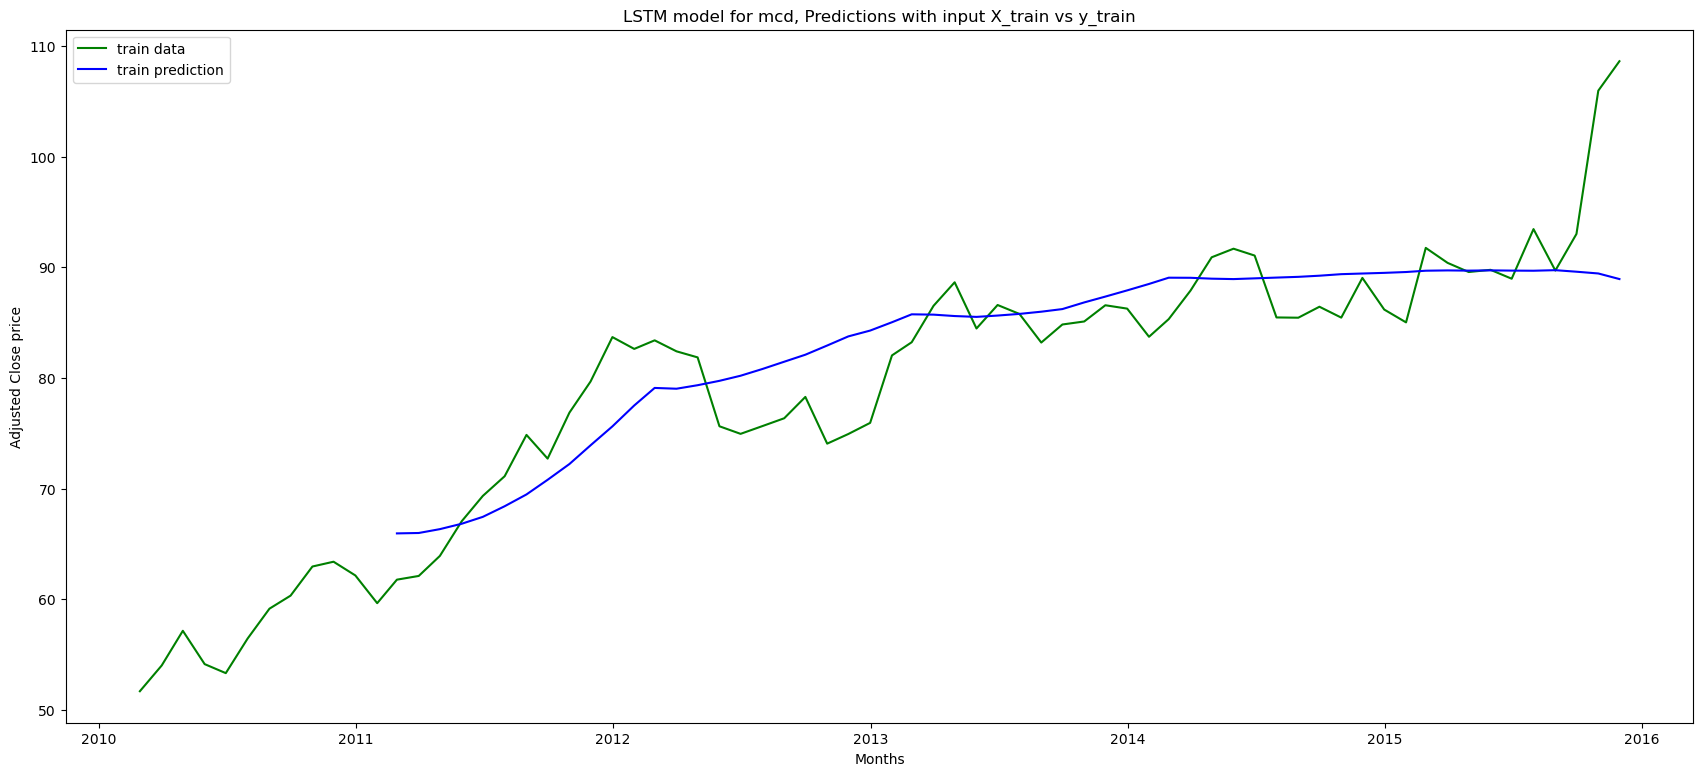

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


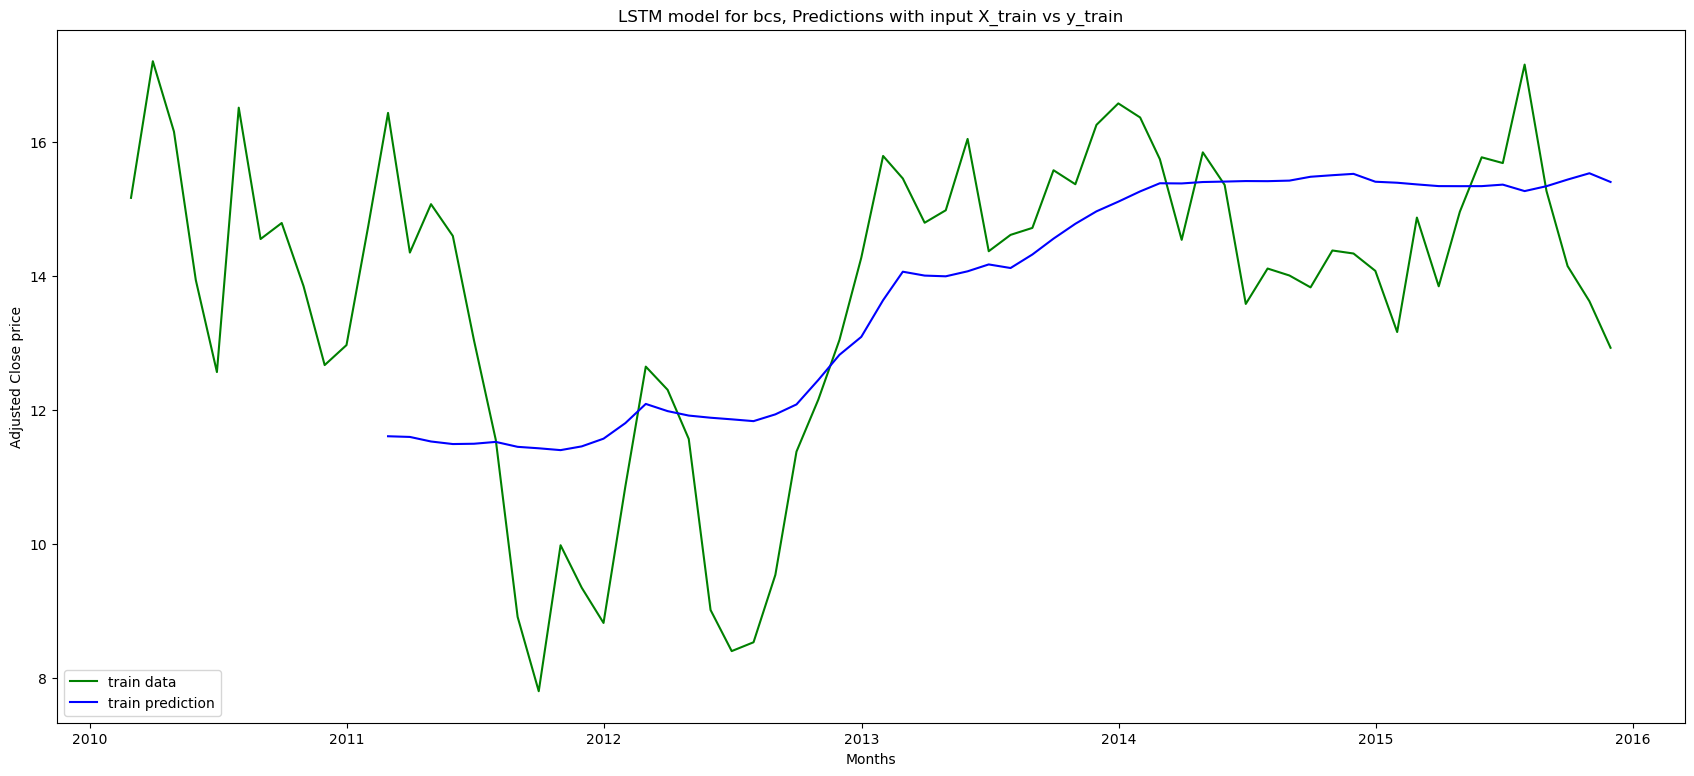

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


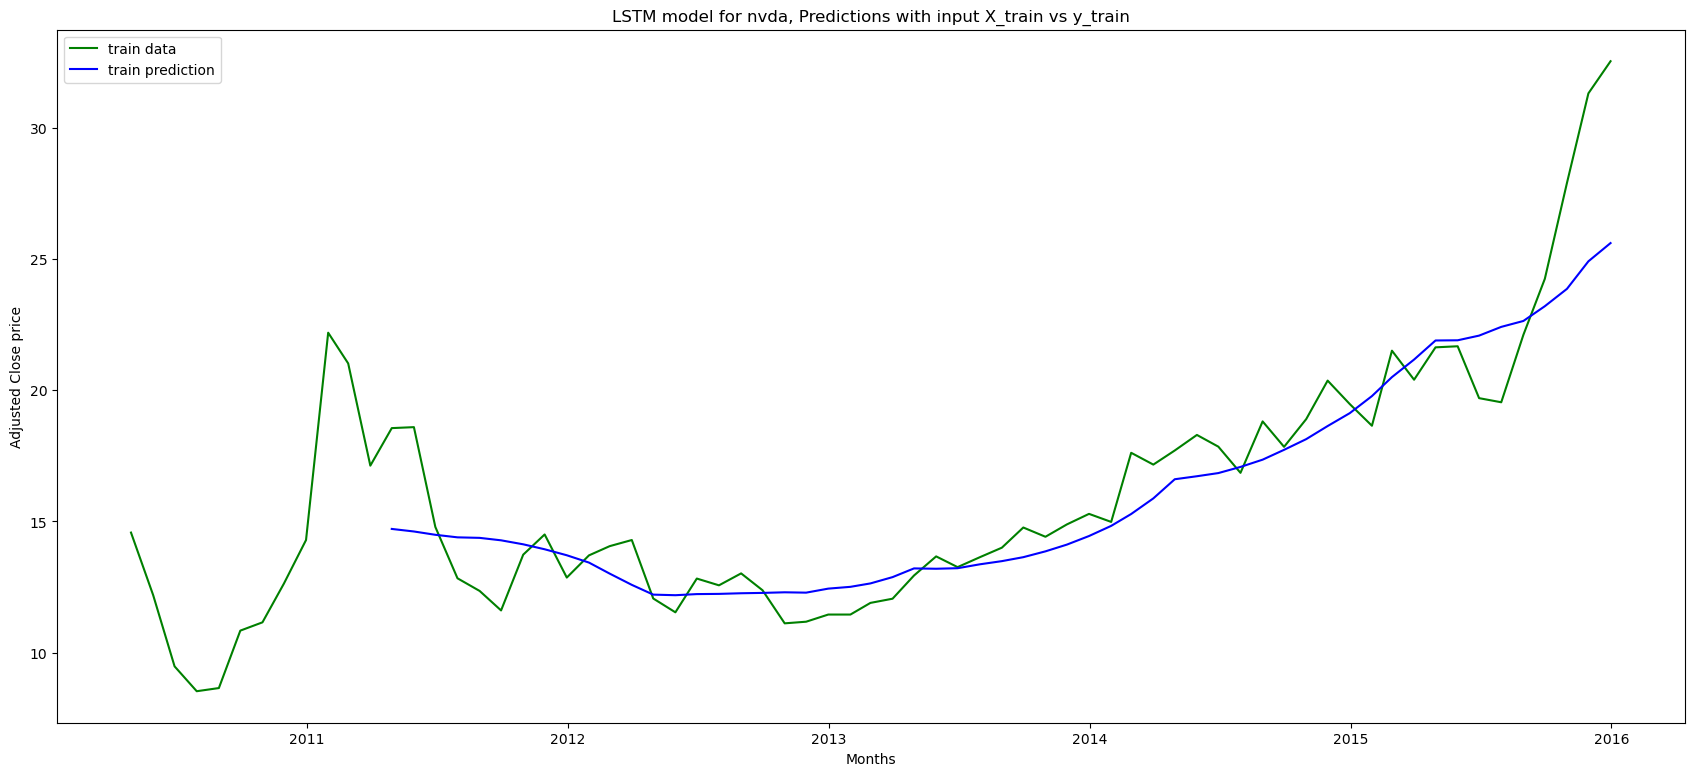

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


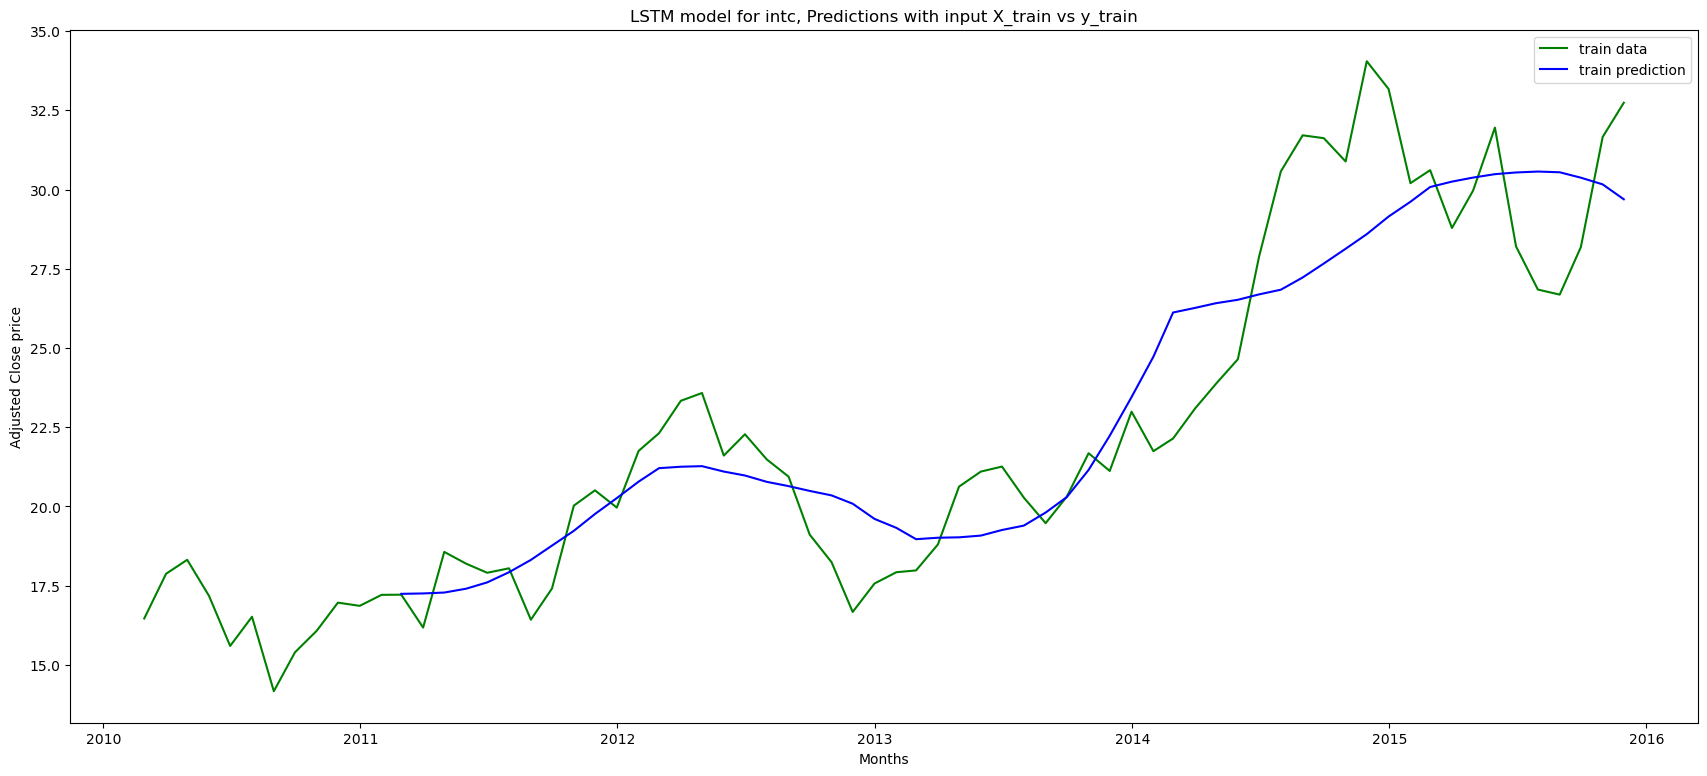

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


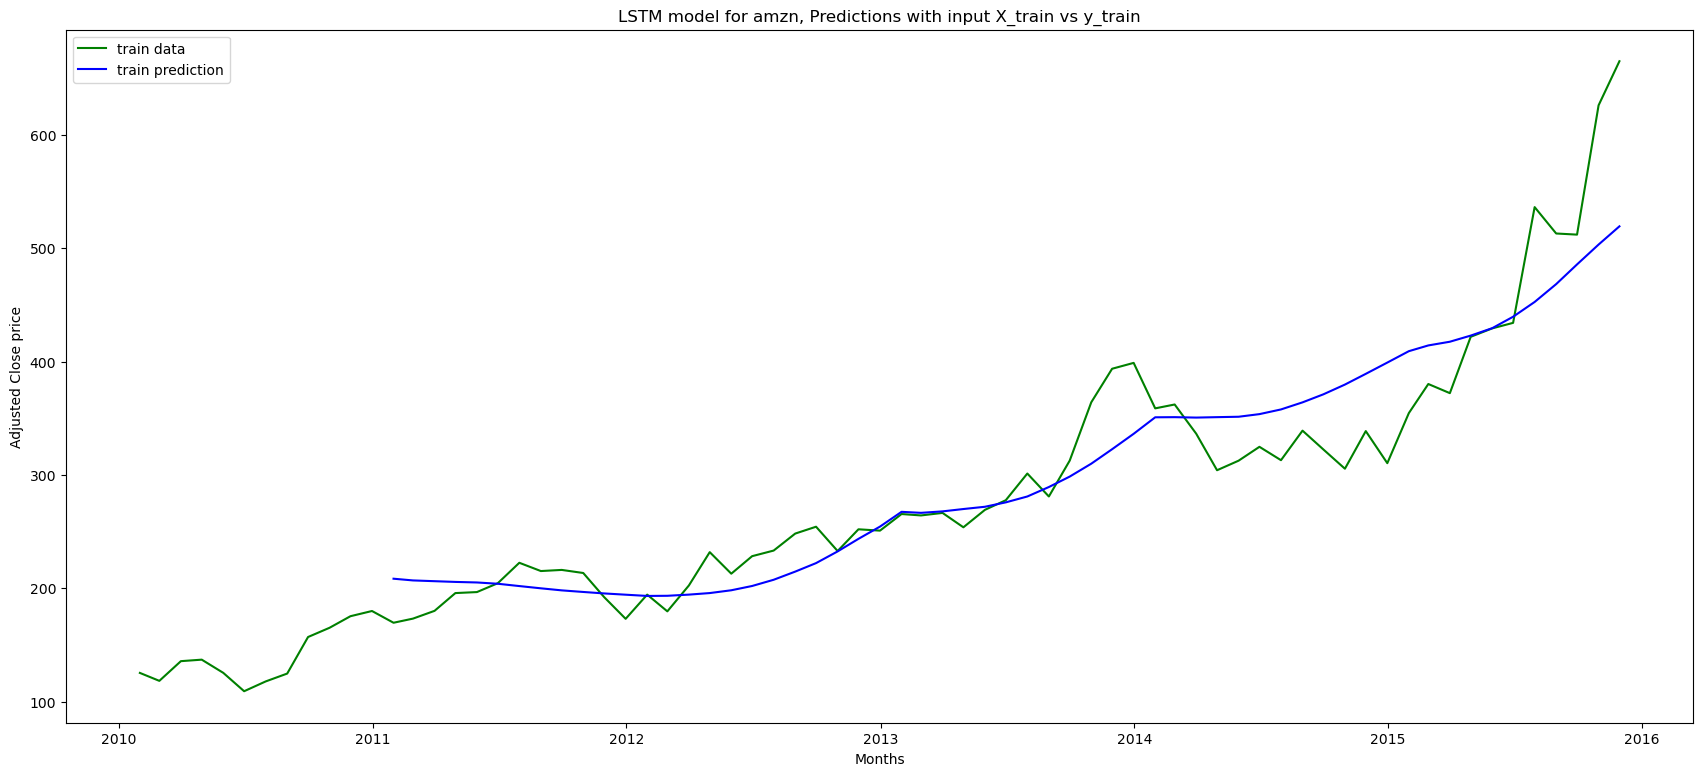

In [82]:
y_preds = {}

for t in tickers:
    y_preds[t] = models[t].predict(X_trains[t])  # predictions
    
    # Create a dummy array with the same shape as the scaled input data
    dummy_scaled = np.zeros((y_preds[t].shape[0], train_datasets_scaled[t].shape[1])) 
    dummy_scaled[:, 0] = y_preds[t].flatten()  # Assign predictions to the 'Close' column (index 0)

    # Inverse transform using the scaler
    y_preds[t] = scales[t].inverse_transform(dummy_scaled)[:, 0]  # Extract only the 'Close' column
    
    # Visualizing predictions in train dataset
    plt.figure(figsize = (21,9))
    plt.plot(train_dfs[t]['Date'],train_dfs[t]['Close'], color = "g", label = "train data")
    plt.plot(train_dfs[t]['Date'].iloc[Lookback:],y_preds[t], color = "b", label = "train prediction" )
    plt.xlabel("Months")
    plt.ylabel("Adjusted Close price")
    plt.title(f"LSTM model for {t}, Predictions with input X_train vs y_train")
    plt.legend()
    plt.show()

Making test predictions.

In [84]:
y_test_preds = {}

for t in tickers:
    # predictions for test
    y_test_preds[t] = models[t].predict(X_tests[t])
    
    # Create a dummy array with the same shape as the scaled input data
    dummy_scaled = np.zeros((y_test_preds[t].shape[0], test_datasets_scaled[t].shape[1])) 
    dummy_scaled[:, 0] = y_test_preds[t].flatten()  # Assign predictions to the 'Close' column (index 0)

    # Inverse transform using the scaler
    y_test_preds[t] = test_scales[t].inverse_transform(dummy_scaled)[:, 0]  # Extract only the 'Close' column


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Making combined charts with train and test data and predictions.

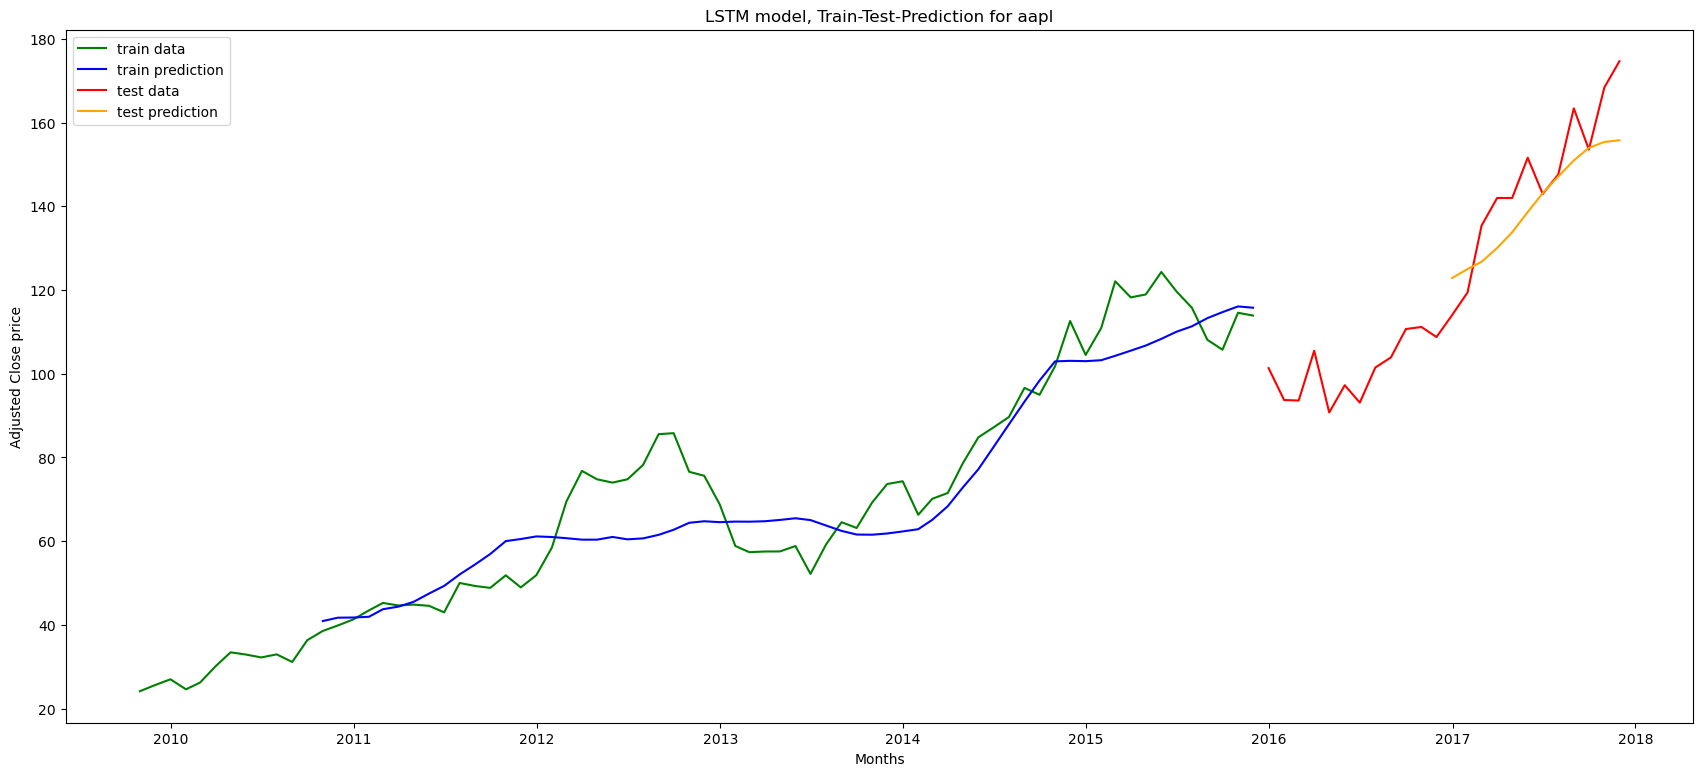

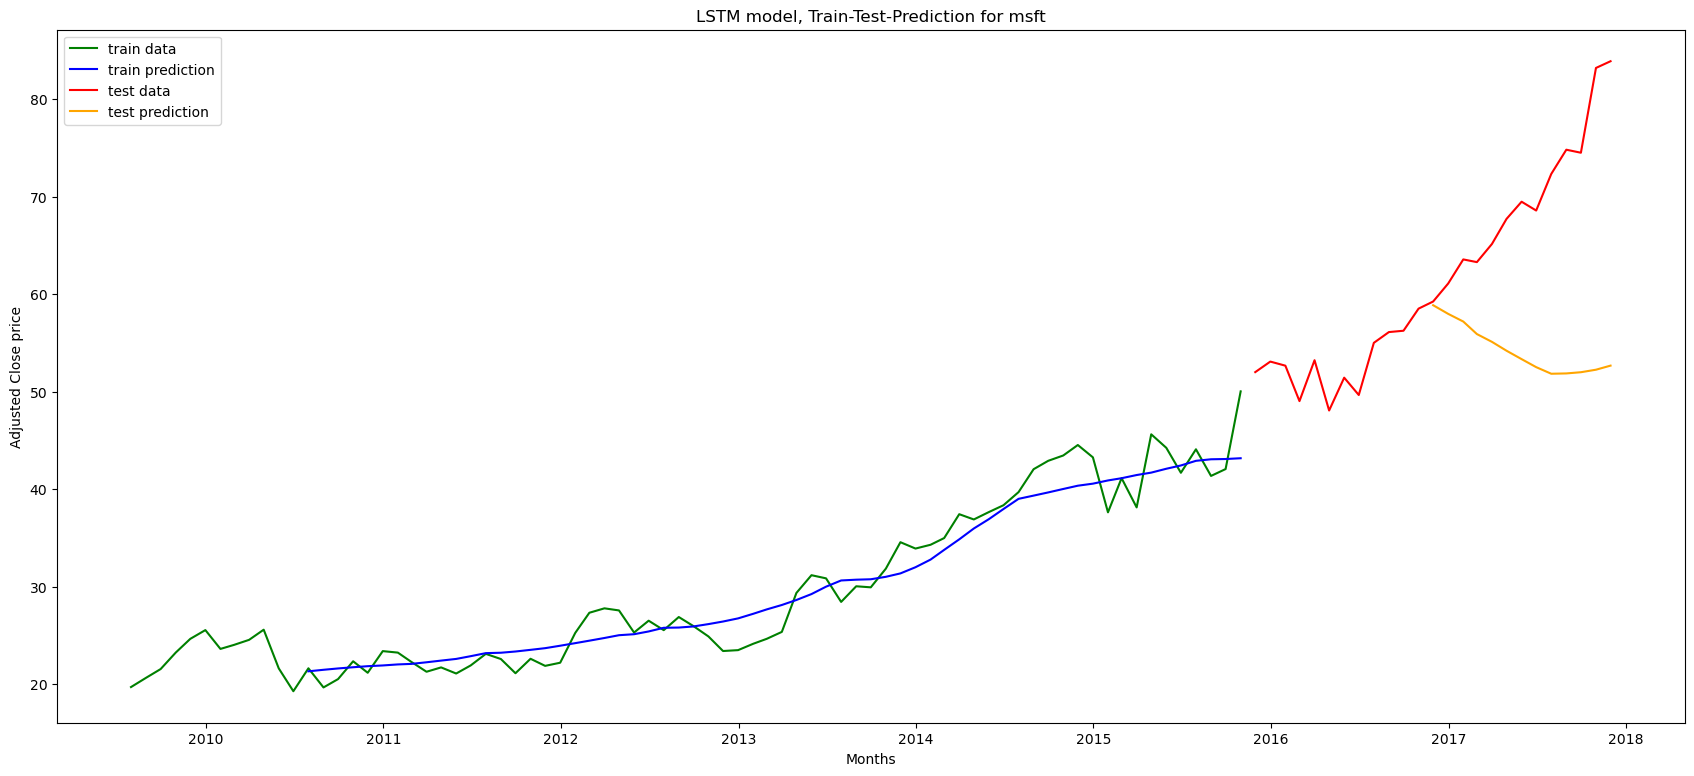

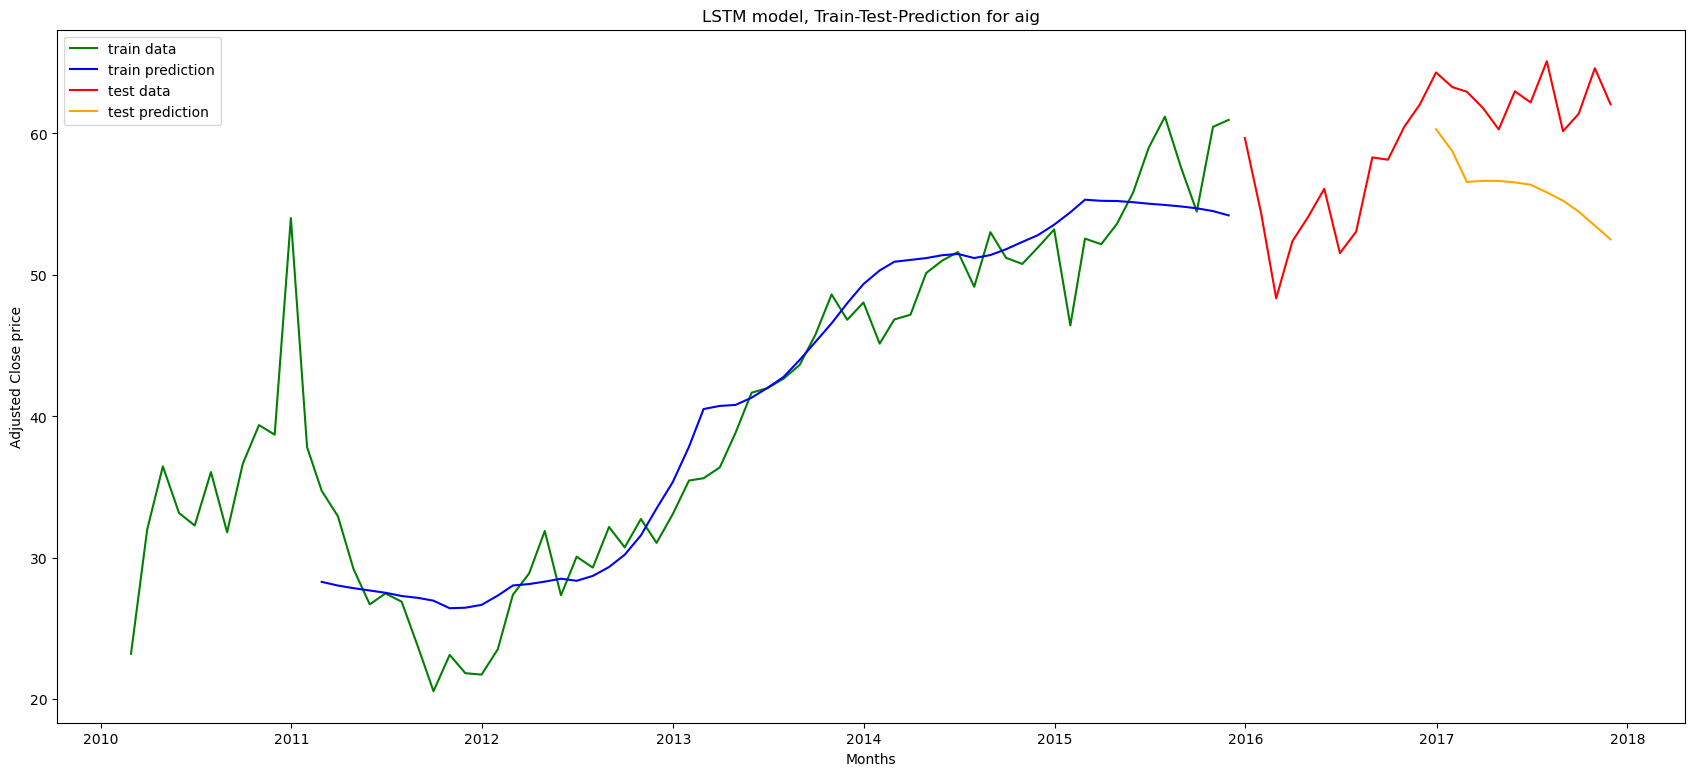

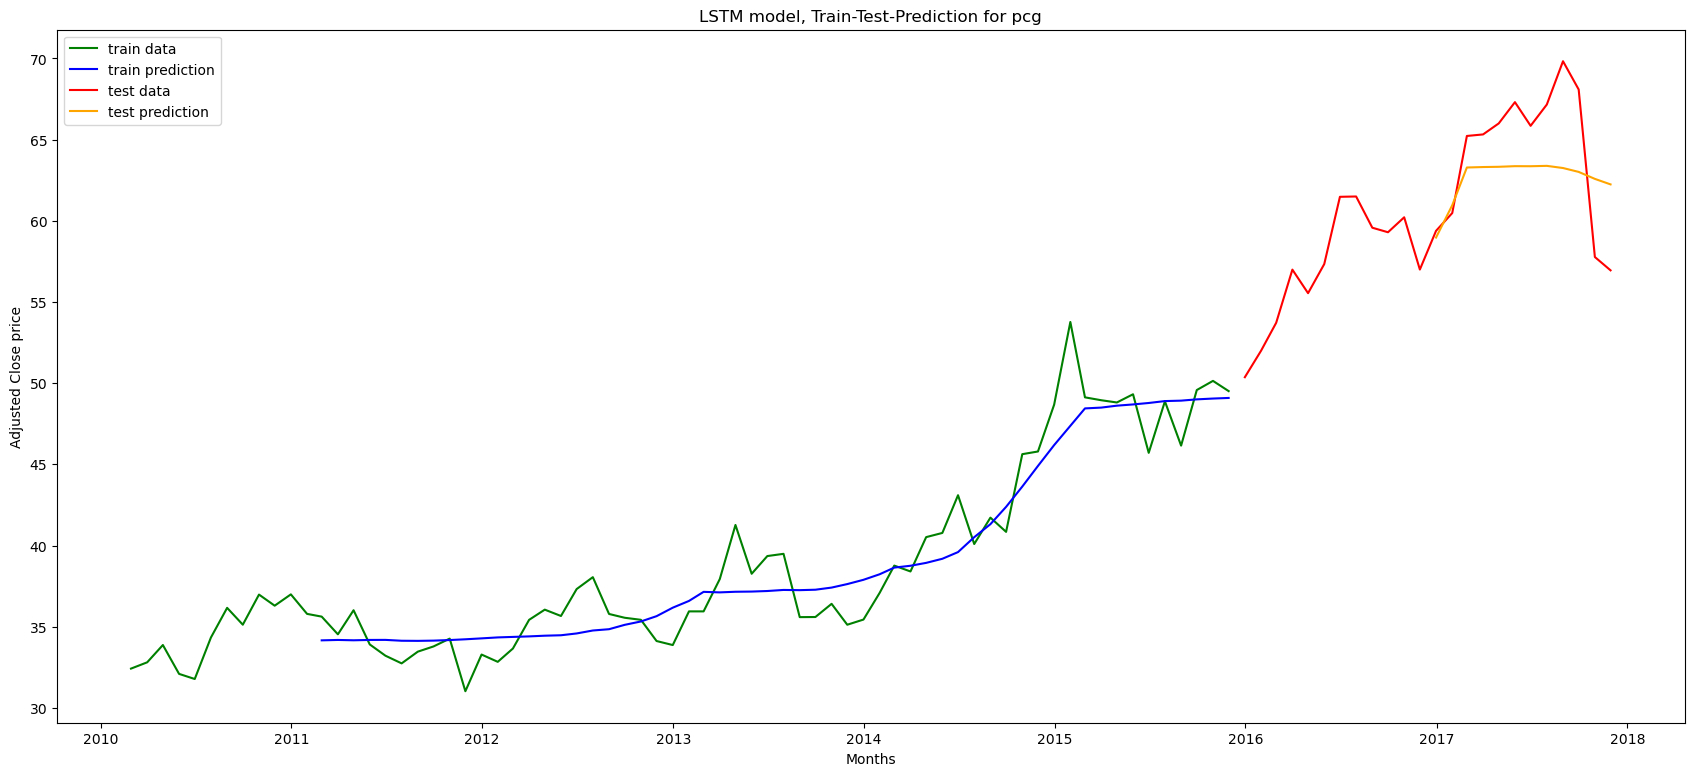

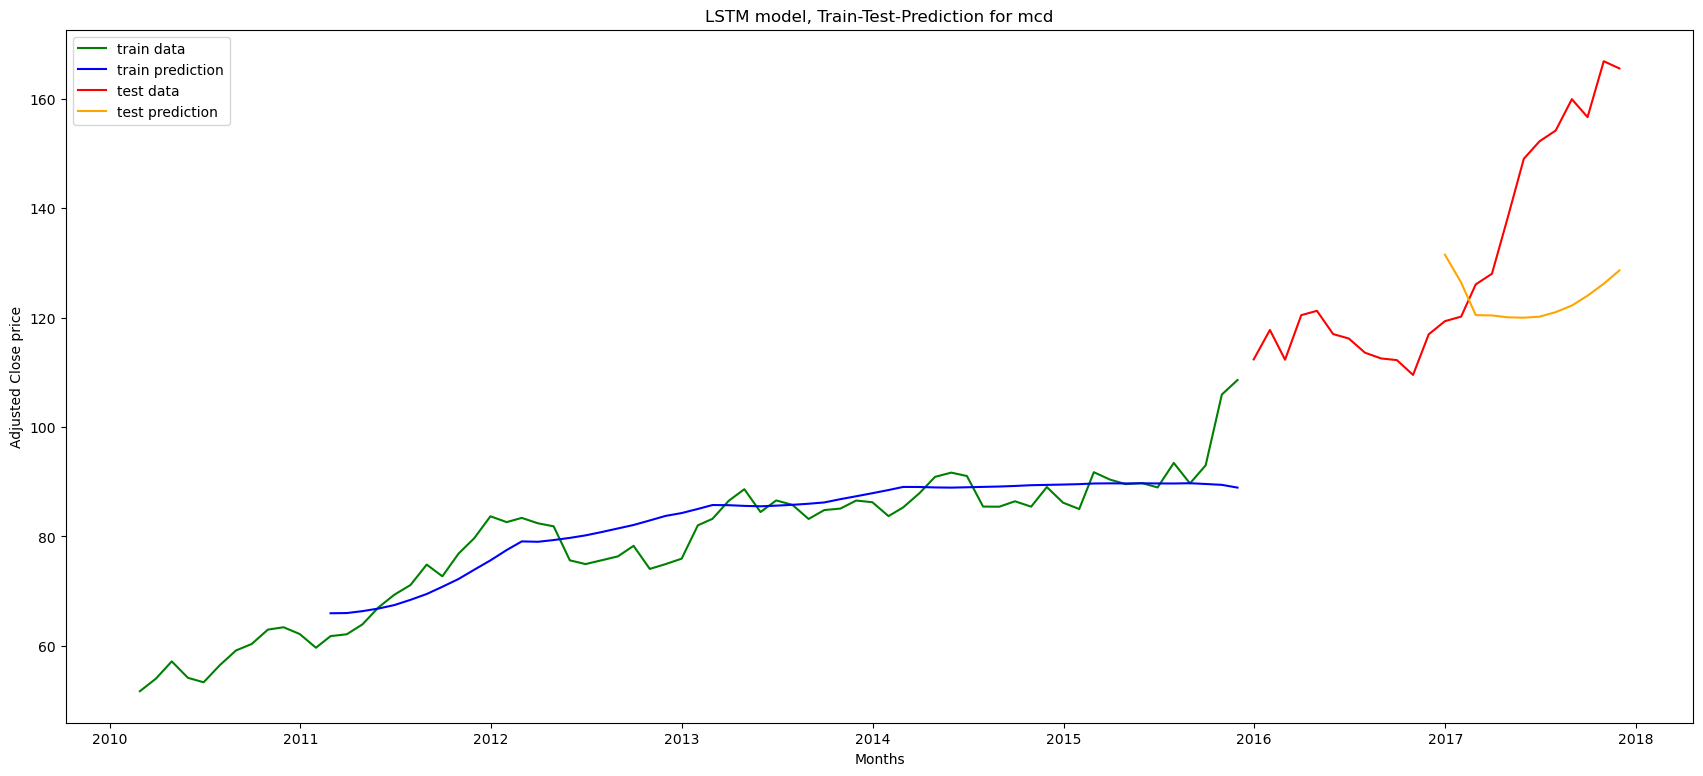

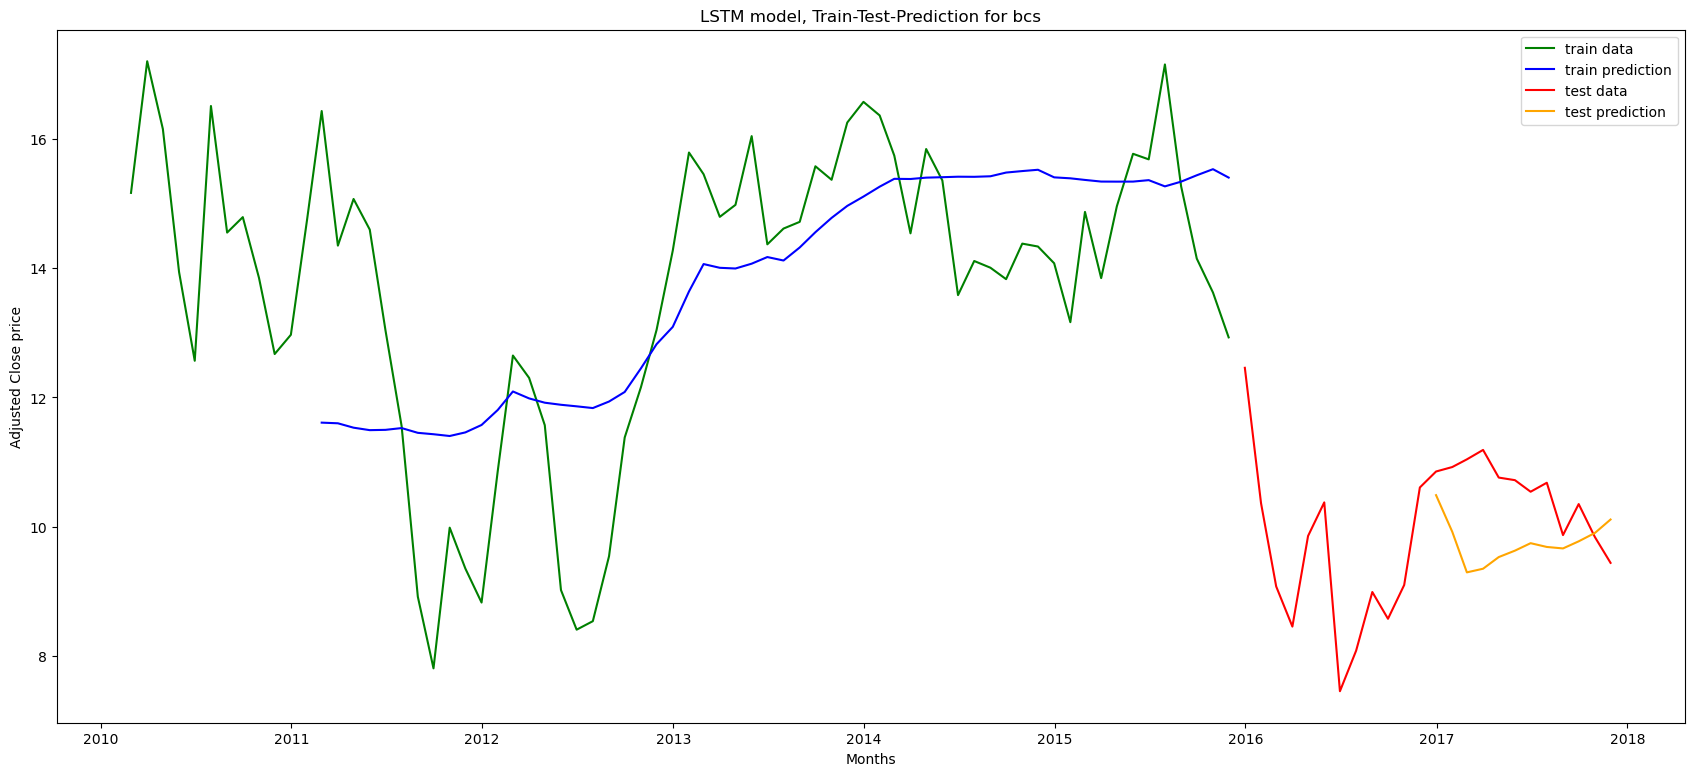

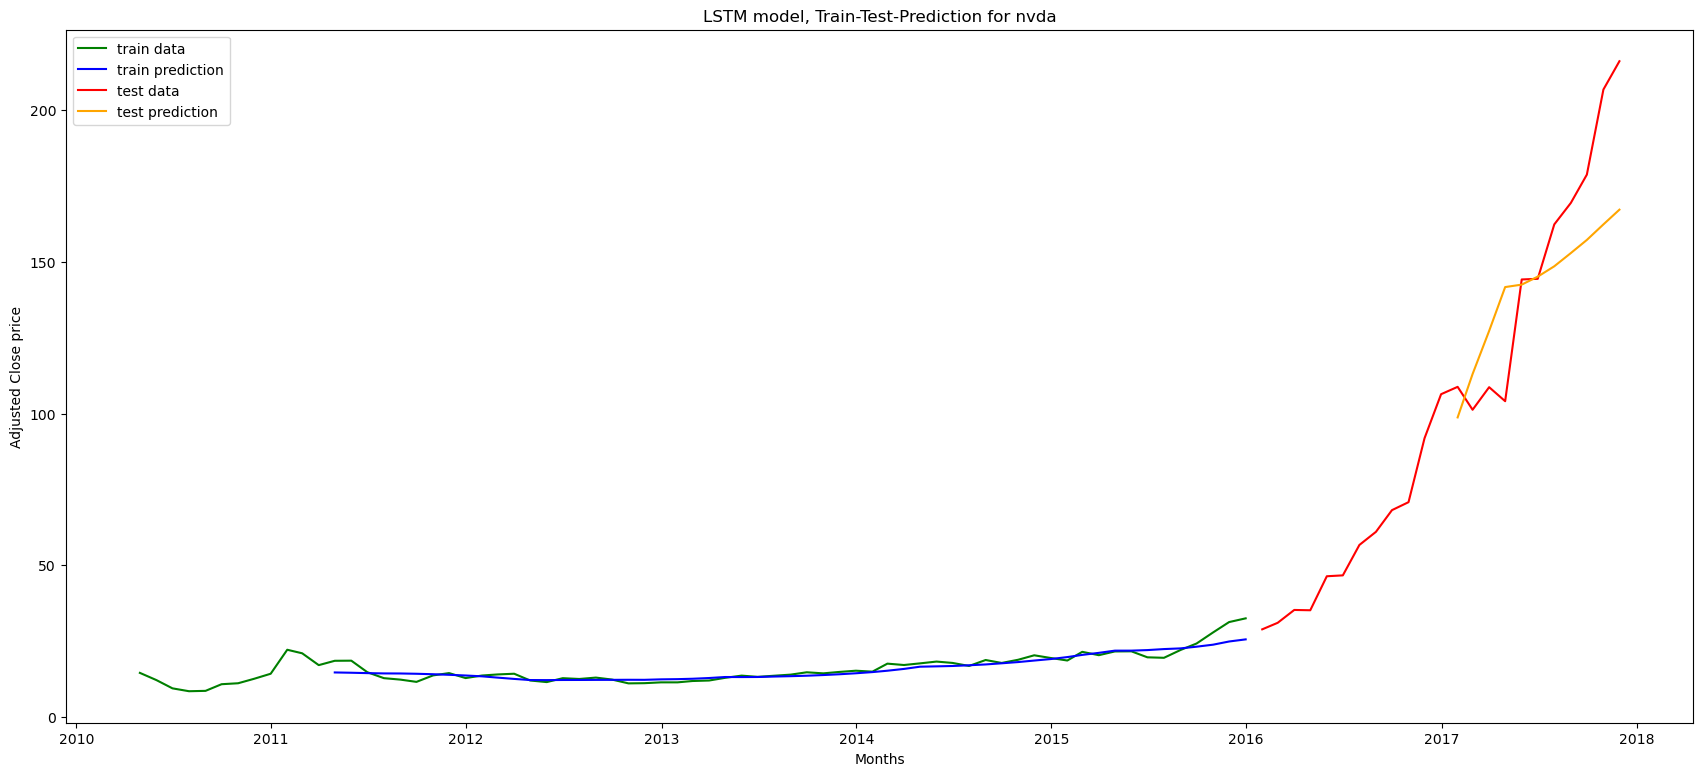

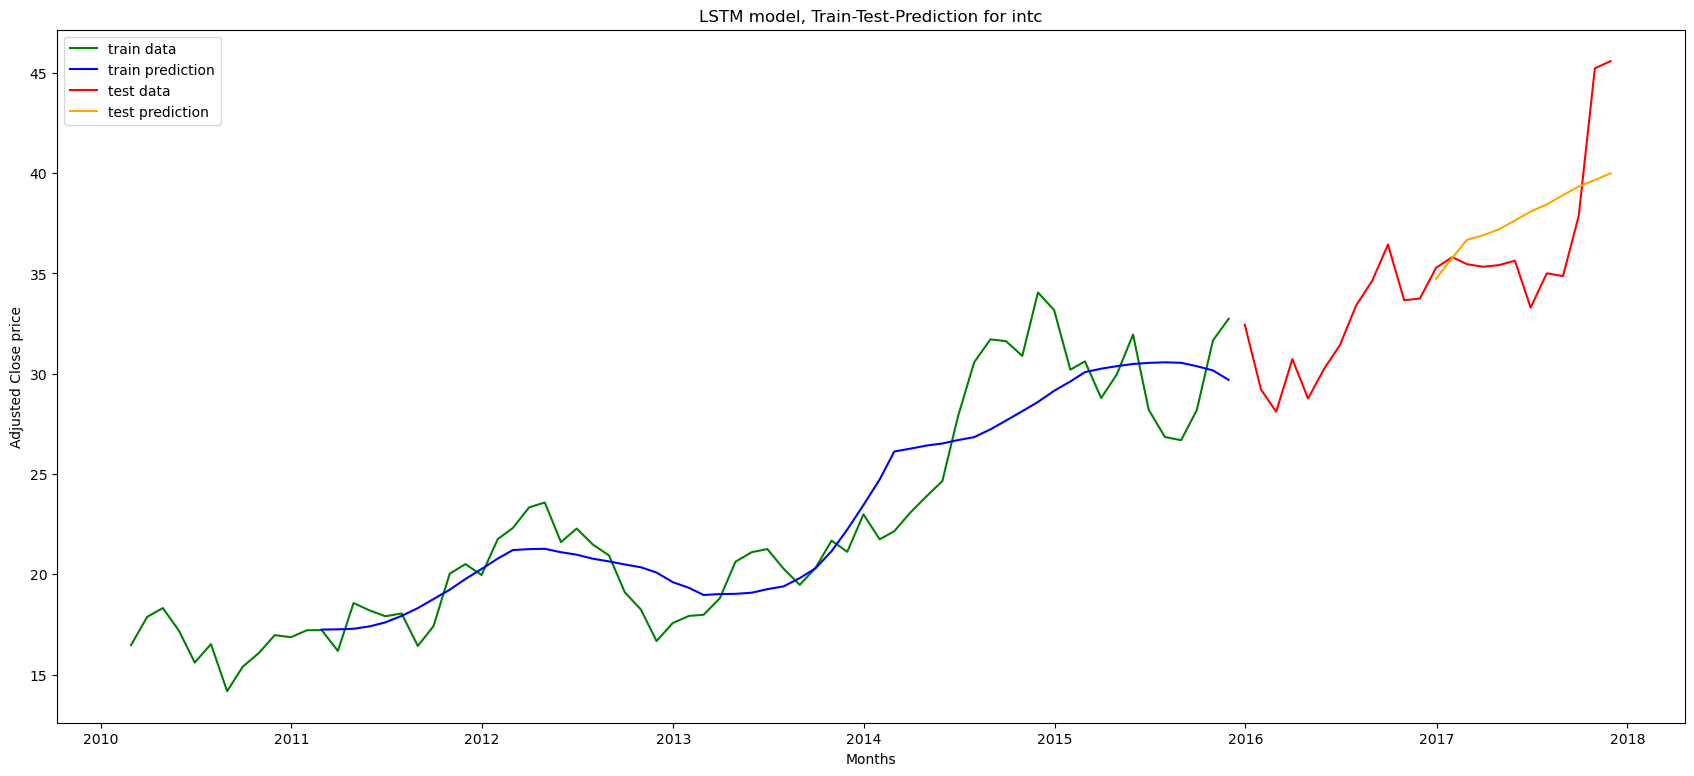

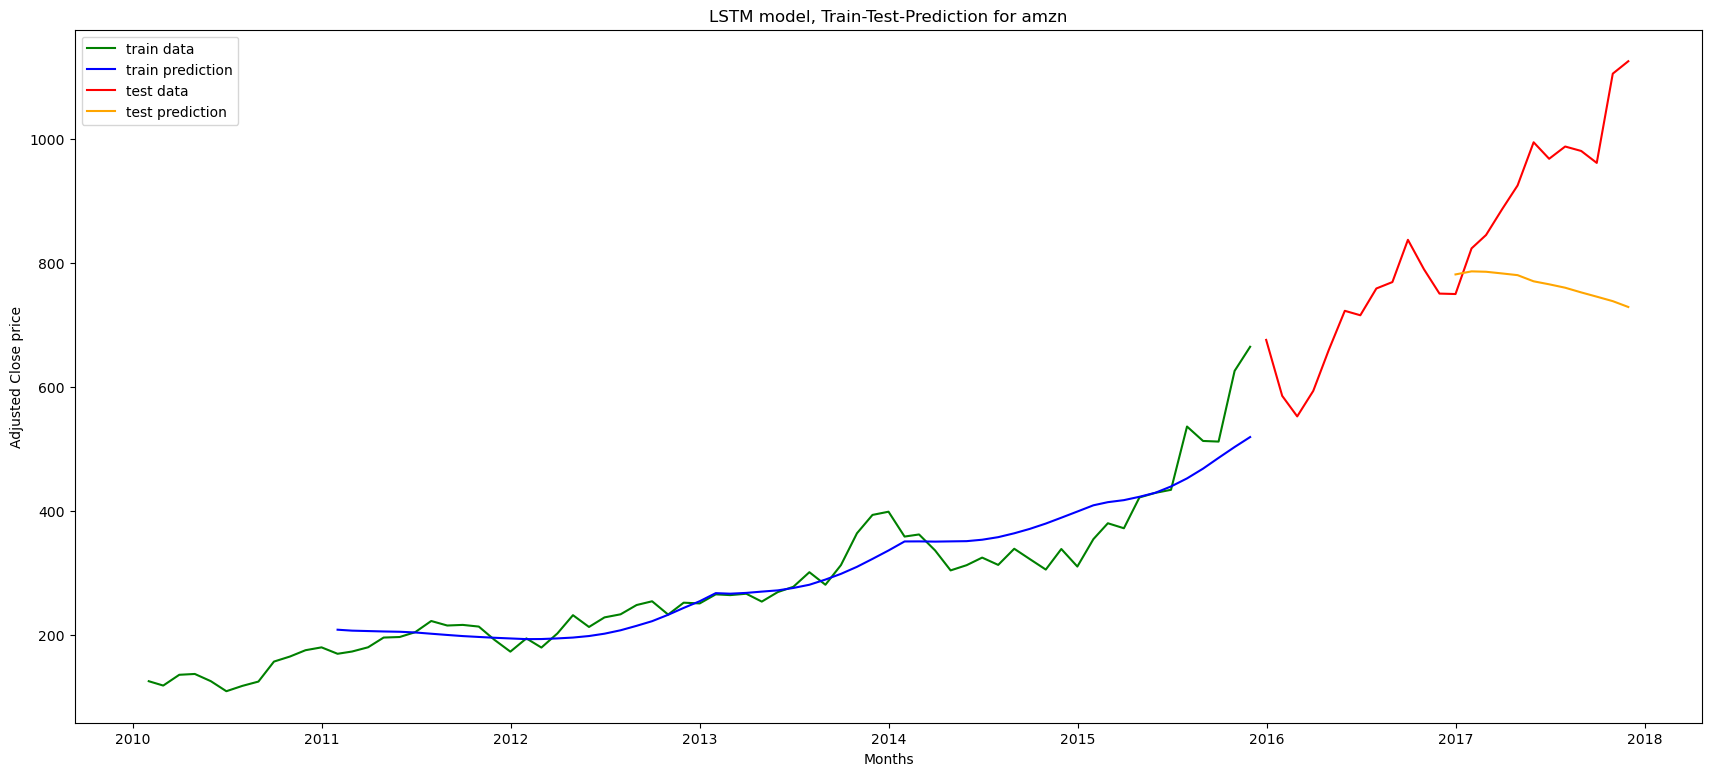

In [86]:
# Combined chart with train and test with predictions
for t in tickers:
    plt.subplots(figsize =(21,9))
    plt.plot(train_dfs[t]['Date'],train_dfs[t]['Close'], color = "g", label = "train data")
    plt.plot(train_dfs[t]['Date'].iloc[Lookback:],y_preds[t], color = "b", label = "train prediction" )
    plt.plot(test_dfs[t]['Date'], test_dfs[t]['Close'], label = "test data", color = "r")
    plt.plot(test_dfs[t]['Date'].iloc[Lookback:], y_test_preds[t], label = "test prediction", color = "orange")
    plt.xlabel("Months")
    plt.ylabel("Adjusted Close price")
    plt.title(f"LSTM model, Train-Test-Prediction for {t}")
    plt.legend()
    plt.show()

Calculating MSE for train and for test.

In [88]:
mse_train, mse_test = {},{}

for t in tickers:
    # Calculating MSE for train 

    # Create a dummy array with the same shape as the scaled input data
    dummy_scaled = np.zeros((y_trains[t].shape[0], train_datasets_scaled[t].shape[1])) 
    dummy_scaled[:, 0] = y_trains[t].flatten()  # Assign predictions to the 'Close' column (index 0)

    # Inverse transform using the scaler
    y_trains_unscaled = scales[t].inverse_transform(dummy_scaled)[:, 0]  # Extract only the 'Close' column
    
    mse_train[t] = mean_squared_error(y_trains_unscaled, y_preds[t])
    print(f'Mean squared error for {t} train {mse_train[t]:.6}')

    # Calculating MSE for test

    # Create a dummy array with the same shape as the scaled input data
    dummy_scaled = np.zeros((y_tests[t].shape[0], test_datasets_scaled[t].shape[1])) 
    dummy_scaled[:, 0] = y_tests[t].flatten()  # Assign predictions to the 'Close' column (index 0)

    # Inverse transform using the scaler
    y_test_unscaled = test_scales[t].inverse_transform(dummy_scaled)[:, 0]  # Extract only the 'Close' column
    
    mse_test[t] = mean_squared_error(y_test_unscaled, y_test_preds[t])
    print(f'Mean squared error for {t} test {mse_test[t]:.6}')

Mean squared error for aapl train 85.6344
Mean squared error for aapl test 103.808
Mean squared error for msft train 4.49916
Mean squared error for msft test 329.818
Mean squared error for aig train 10.1466
Mean squared error for aig test 47.0768
Mean squared error for pcg train 3.40764
Mean squared error for pcg test 14.3017
Mean squared error for mcd train 25.3697
Mean squared error for mcd test 757.771
Mean squared error for bcs train 3.2102
Mean squared error for bcs test 1.06098
Mean squared error for nvda train 3.54365
Mean squared error for nvda test 663.456
Mean squared error for intc train 4.62177
Mean squared error for intc test 10.571
Mean squared error for amzn train 1718.91
Mean squared error for amzn test 47581.3


Calculating MSE with actual vs. SMA. SMA serves as a baseline prediction. Should be compared with MSE for test.

In [90]:
sma_window = 8
sma = {}
mse_sma = {}

for t in tickers:
    # Calculating SMA
    sma[t] = stock_dfs[t]['Close'].rolling(sma_window).mean()
    # Calculating MSE for SMA as a baseline
    mse_sma[t] = mean_squared_error(stock_dfs[t]['Close'].iloc[sma_window - 1:], sma[t].dropna())
    print(f'Mean squared error for {t} sma baseline {mse_sma[t]:.6}')

Mean squared error for aapl sma baseline 110.728
Mean squared error for msft sma baseline 12.6554
Mean squared error for aig sma baseline 18.6416
Mean squared error for pcg sma baseline 9.05872
Mean squared error for mcd sma baseline 57.1508
Mean squared error for bcs sma baseline 2.89634
Mean squared error for nvda sma baseline 226.485
Mean squared error for intc sma baseline 6.17442
Mean squared error for amzn sma baseline 3428.65


Charting everything and SMA in addition

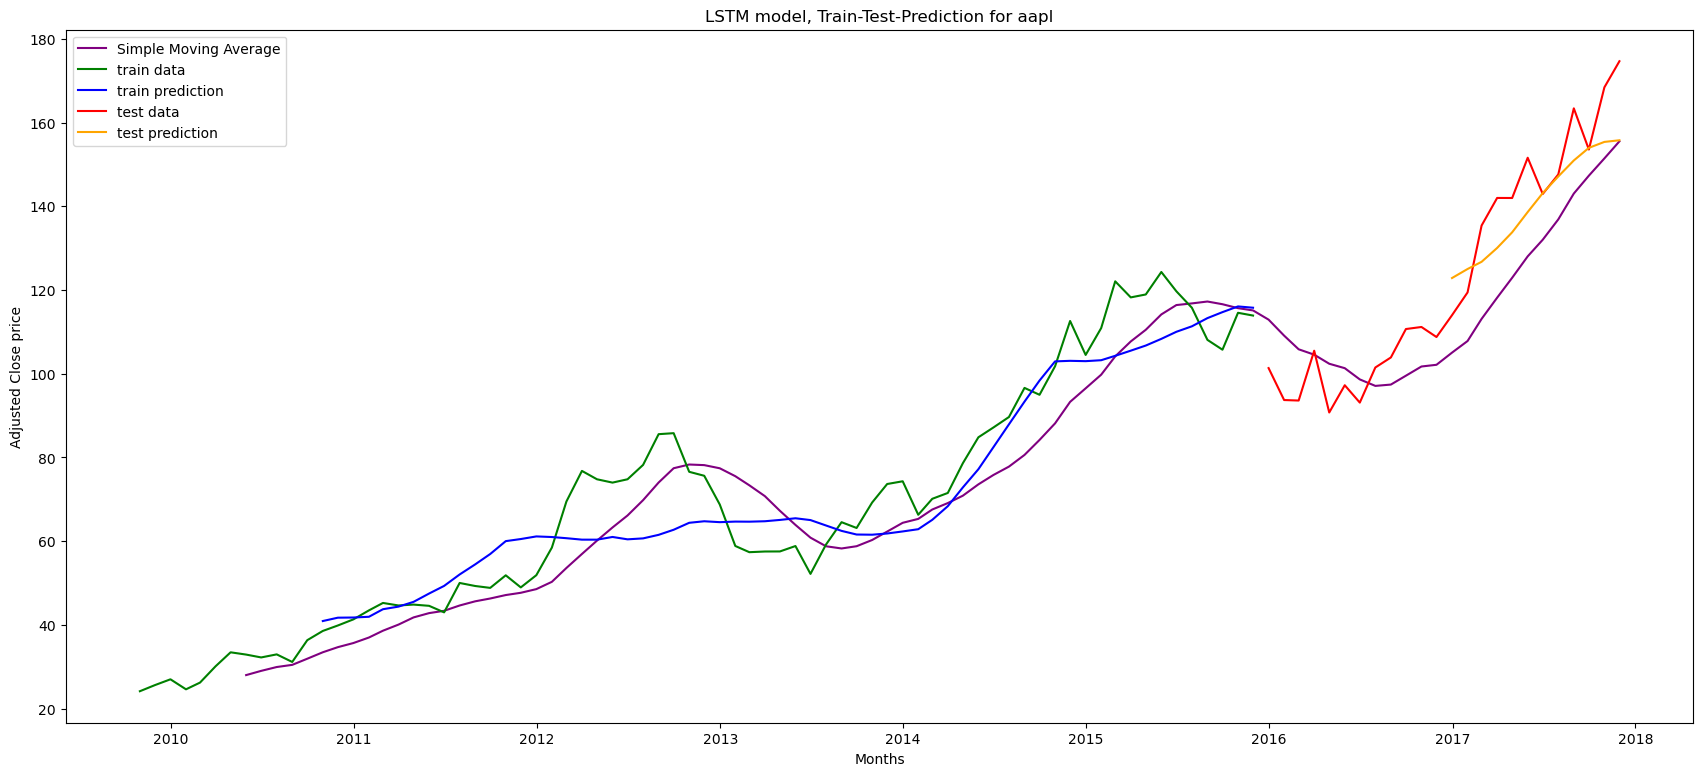

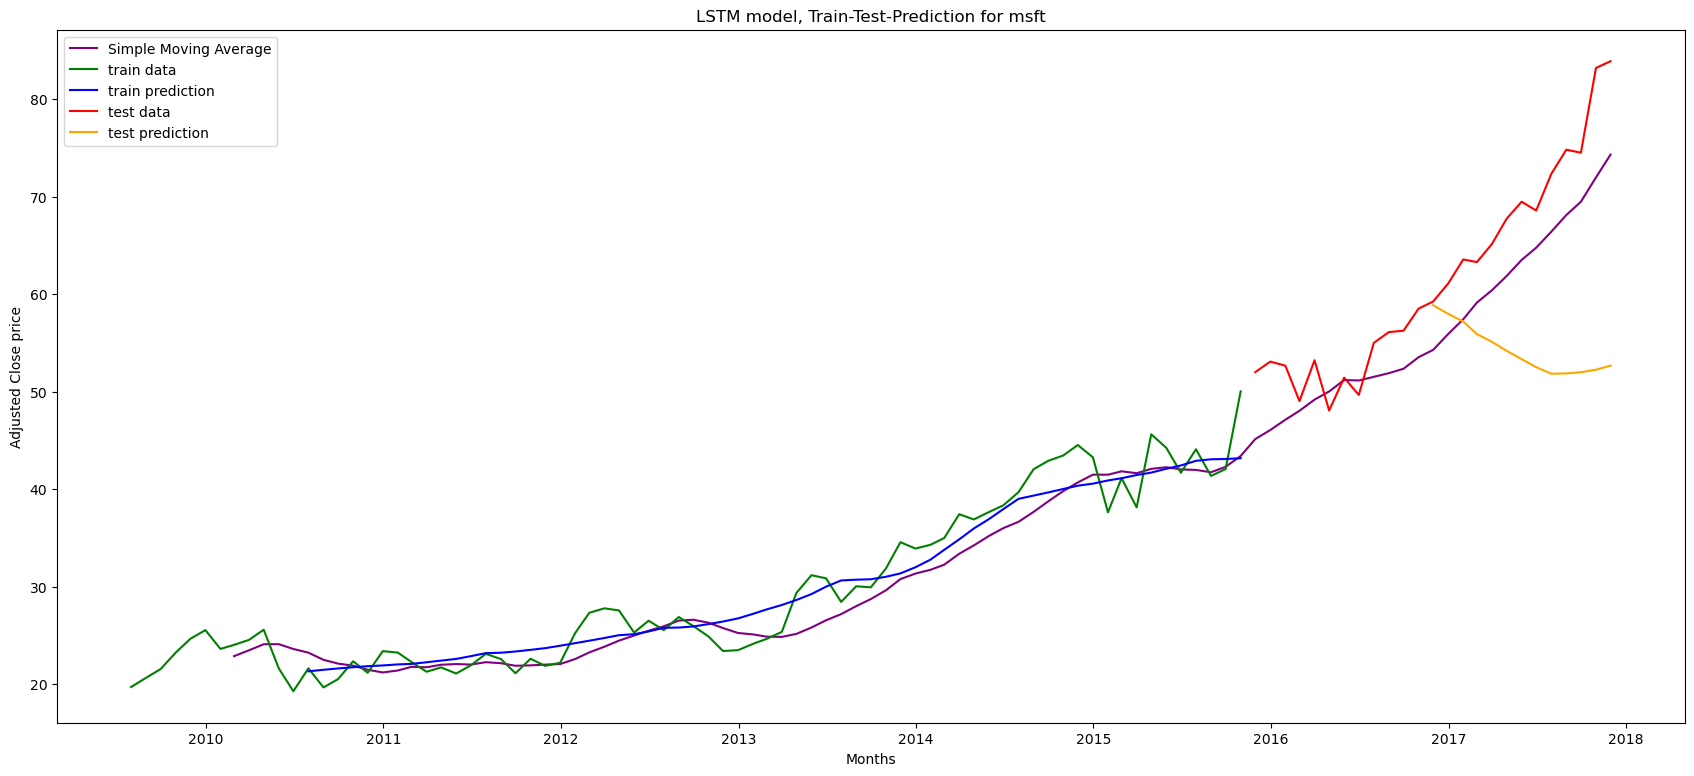

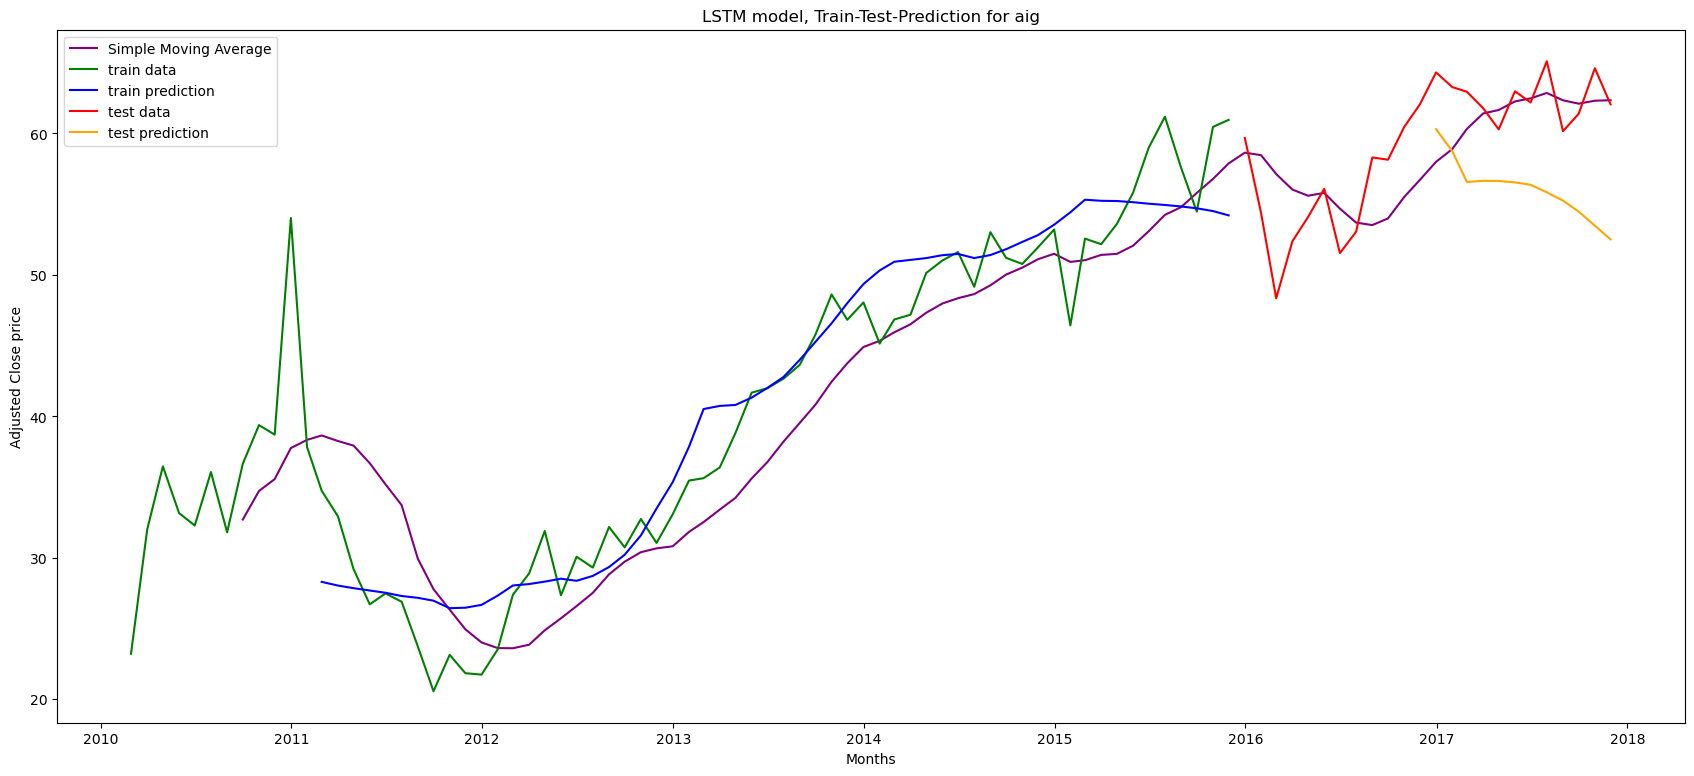

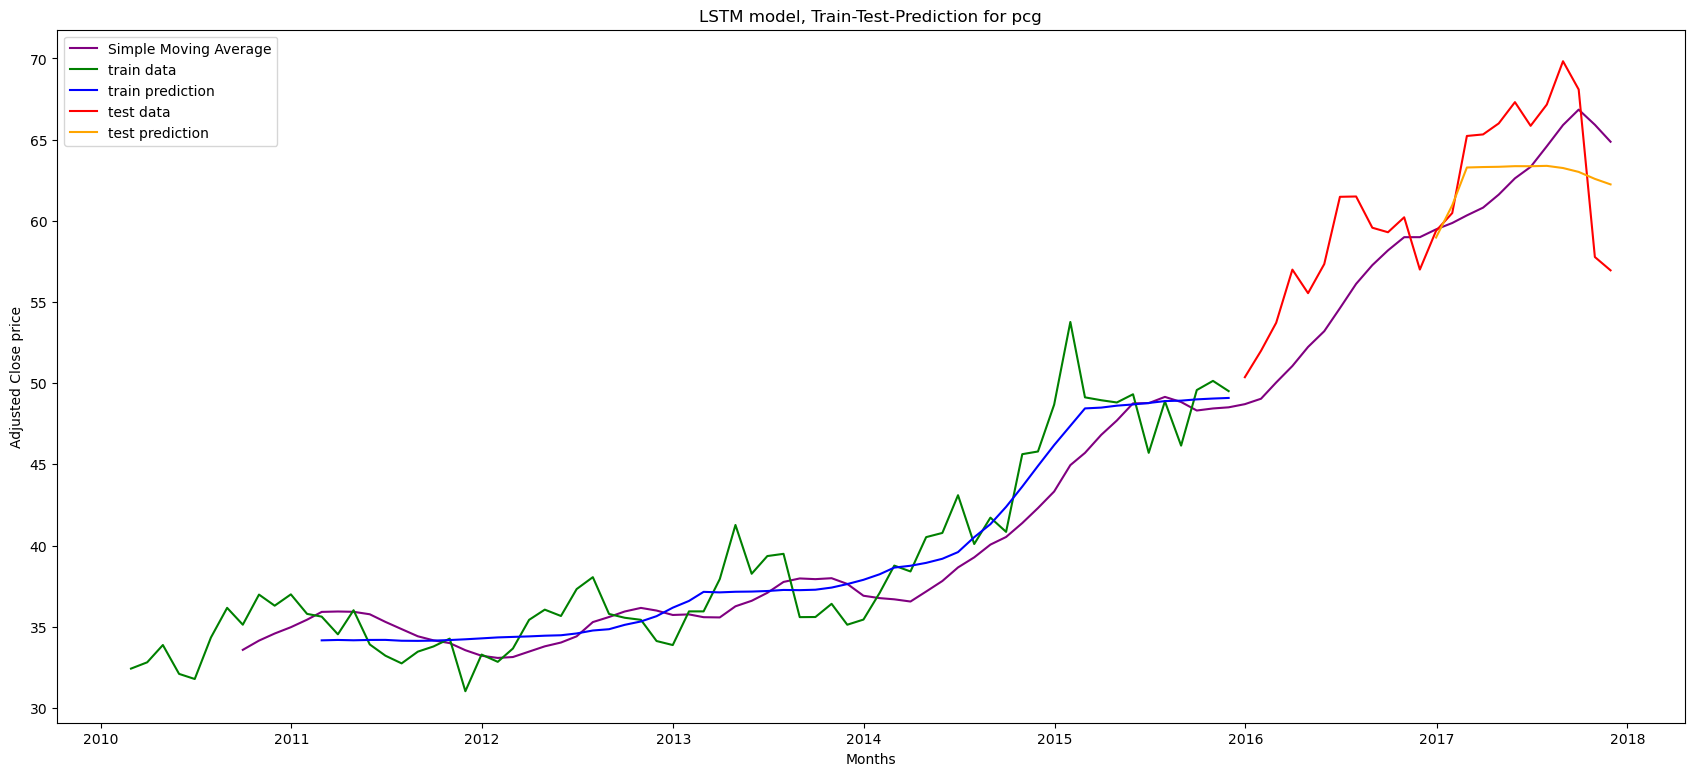

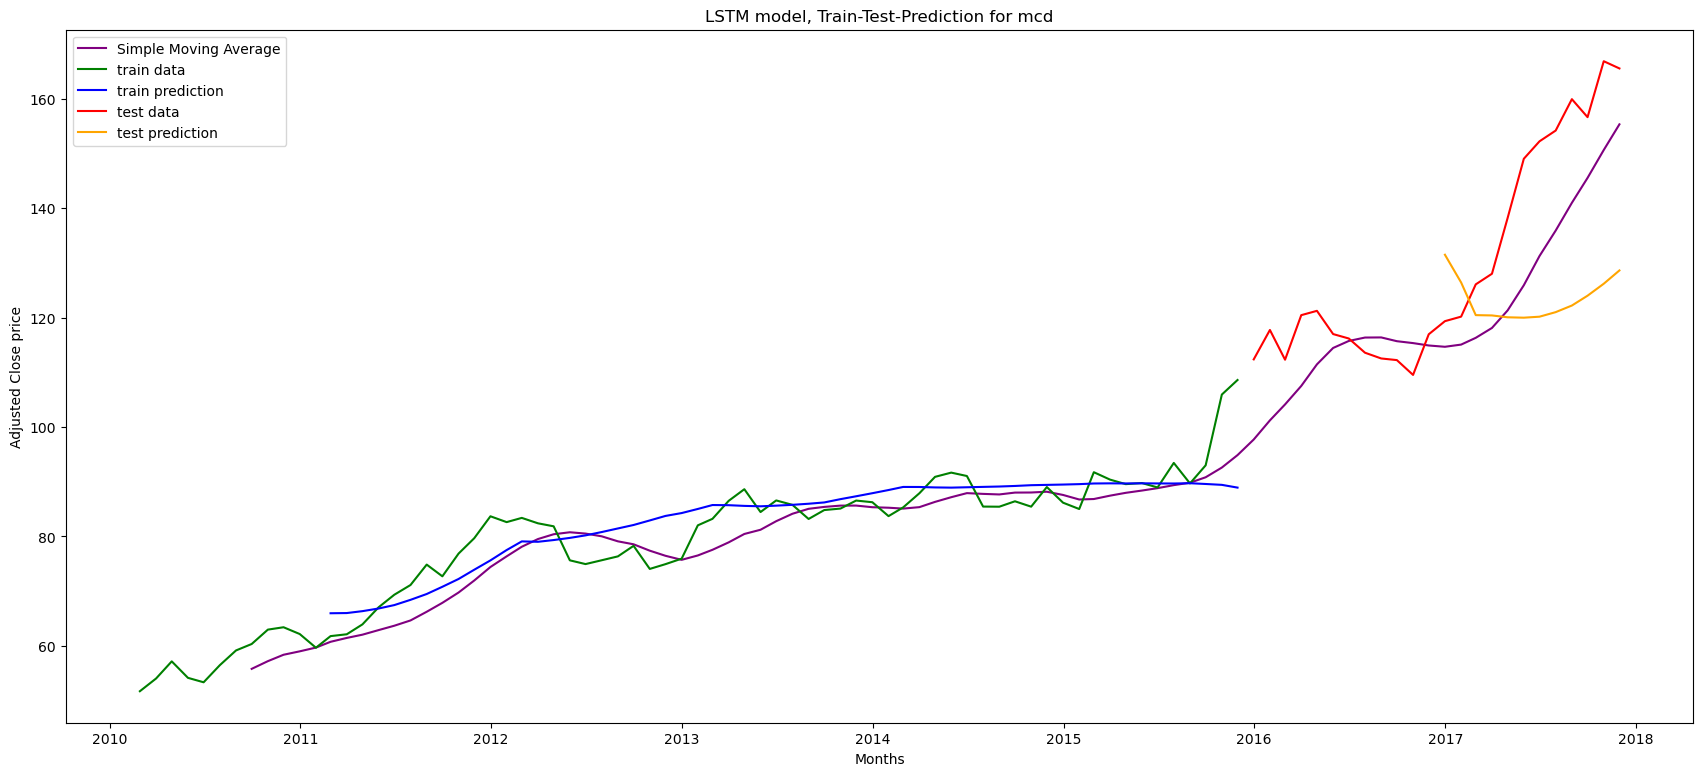

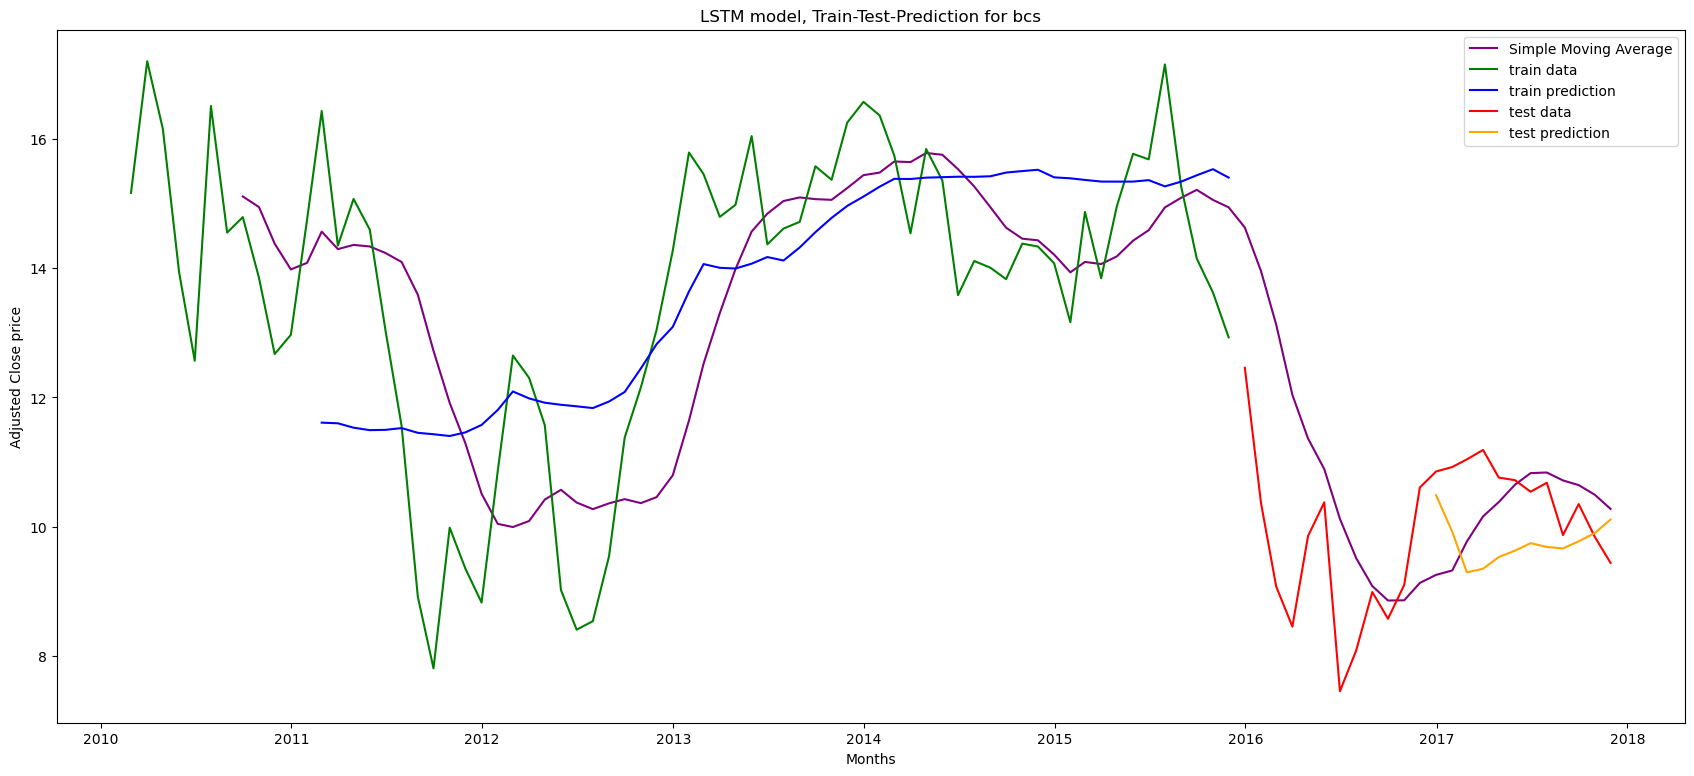

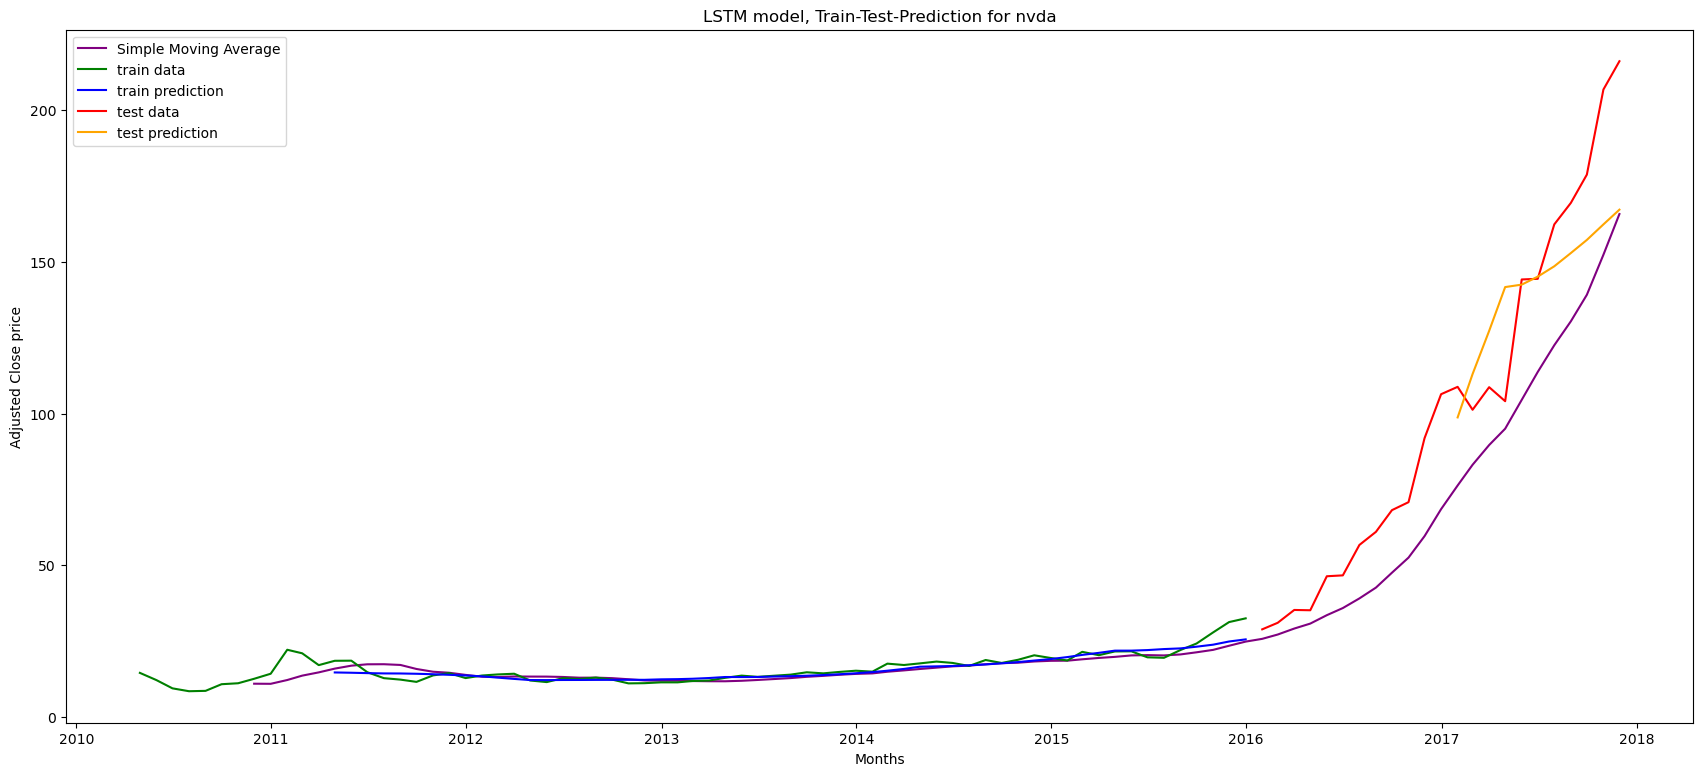

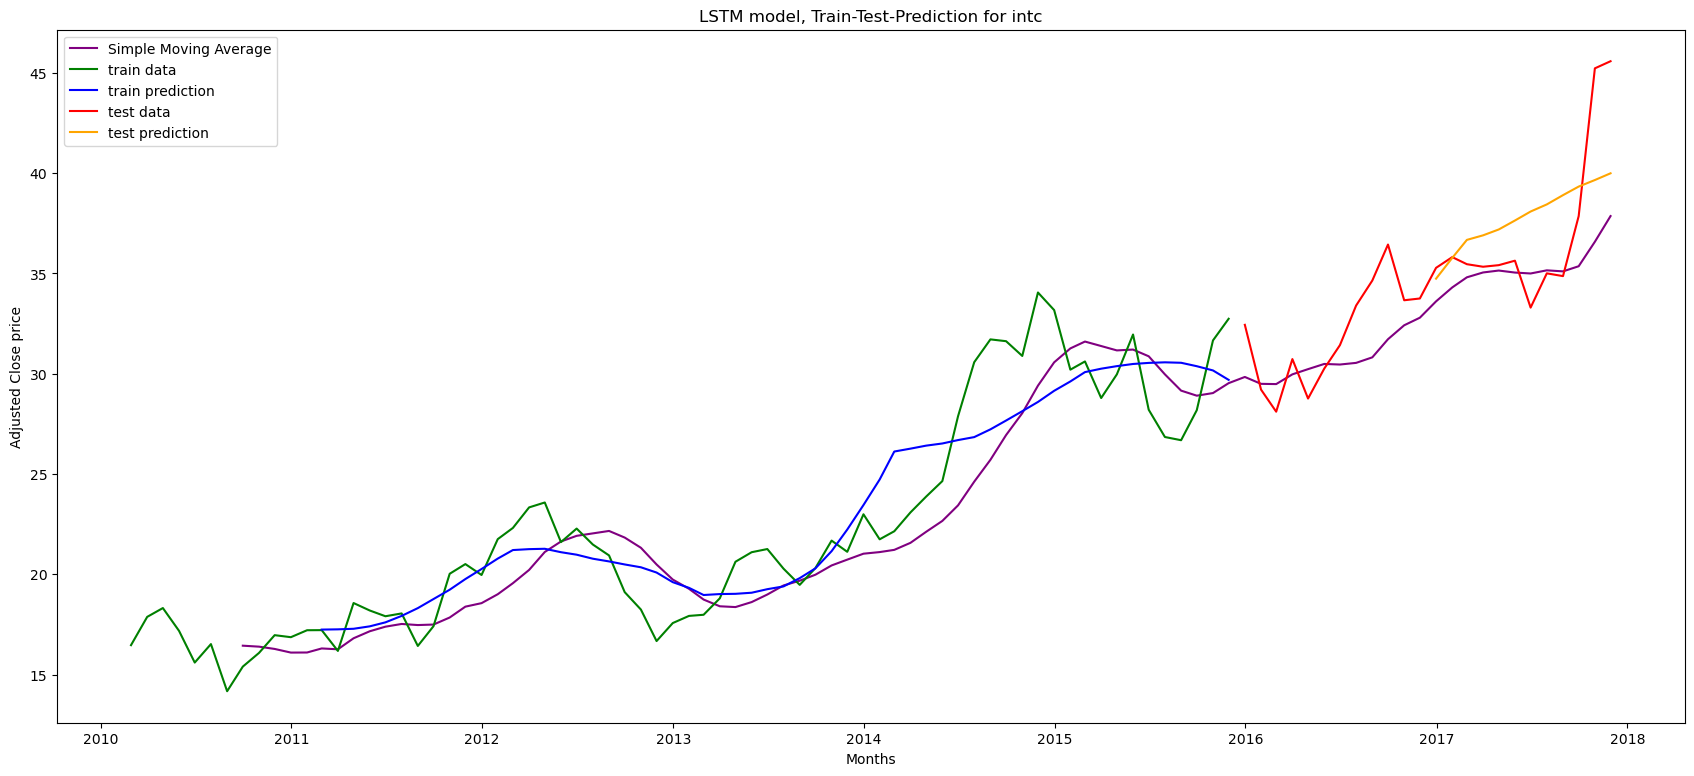

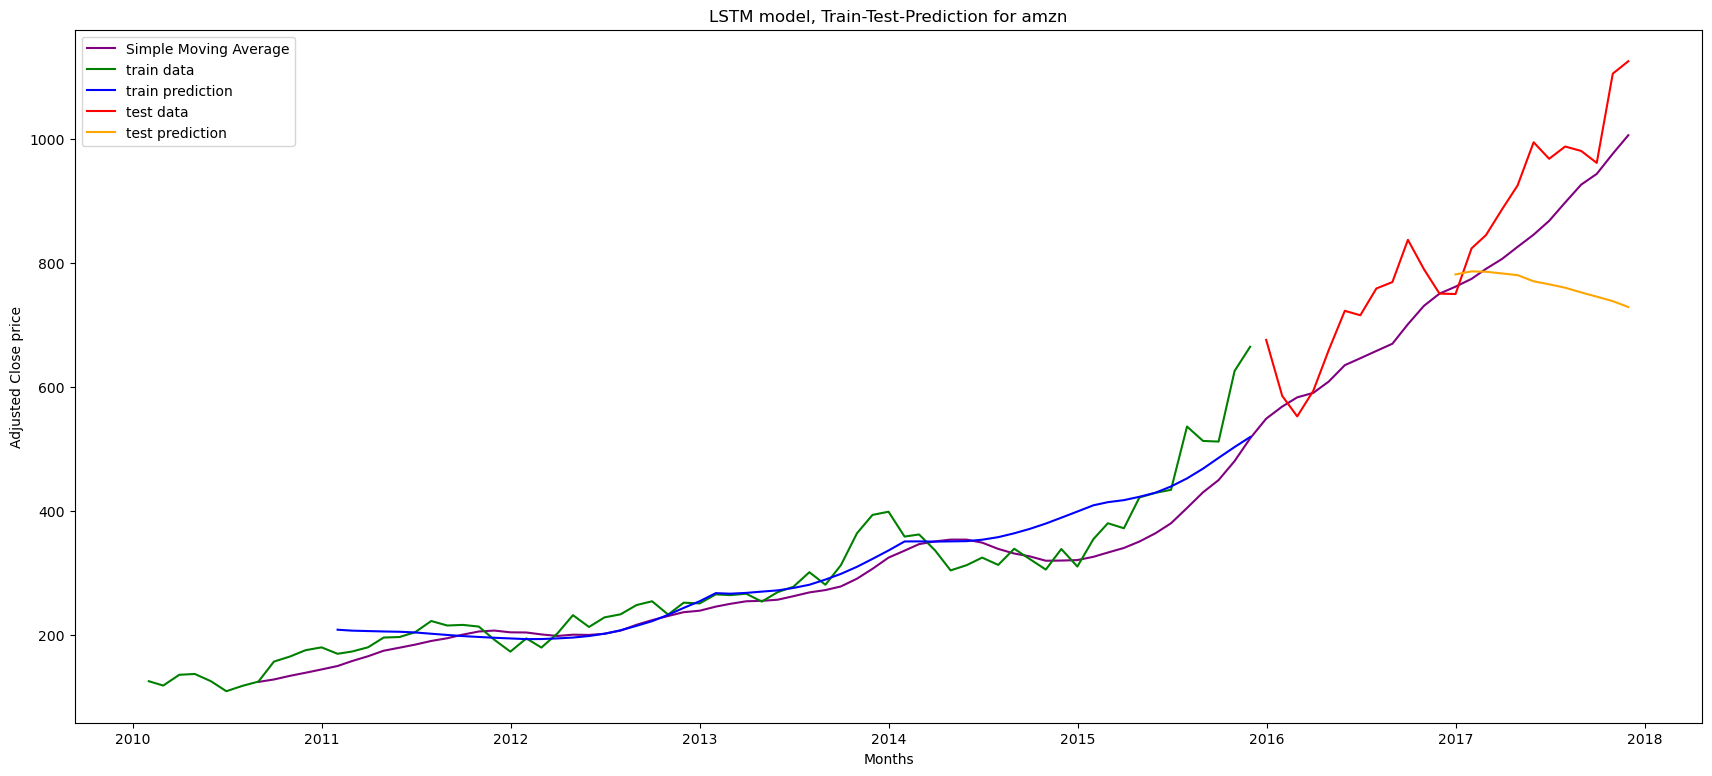

In [92]:
for t in tickers:
    plt.subplots(figsize =(21,9))
    # Adding SMA to plot
    plt.plot(stock_dfs[t]['Date'], sma[t], label = "Simple Moving Average", color = "purple")
    plt.plot(train_dfs[t]['Date'],train_dfs[t]['Close'], color = "g", label = "train data")
    plt.plot(train_dfs[t]['Date'].iloc[Lookback:],y_preds[t], color = "b", label = "train prediction" )
    plt.plot(test_dfs[t]['Date'], test_dfs[t]['Close'], label = "test data", color = "r")
    plt.plot(test_dfs[t]['Date'].iloc[Lookback:], y_test_preds[t], label = "test prediction", color = "orange")
    plt.xlabel("Months")
    plt.ylabel("Adjusted Close price")
    plt.title(f"LSTM model, Train-Test-Prediction for {t}")
    plt.legend()
    plt.show()

Saving mean squared error results into csv for future comparison with mean squared error results of other models.

In [93]:
mse_df_ppfs = pd.DataFrame([mse_test]).T.reset_index()
mse_df_ppfs.columns = ['Ticker', 'MSE_model4']
print(mse_df_ppfs.head())

mse_df = pd.read_csv('../data/results/MSE_test_3models.csv')
mse_df = mse_df.drop(columns='Unnamed: 0', axis=1)
print(mse_df.head())

mse_merged = pd.merge(mse_df, mse_df_ppfs, on='Ticker', how='left')
print(mse_merged)

mse_merged.to_csv('../data/results/MSE_test_4models.csv')

  Ticker  MSE_model4
0   aapl  103.808317
1   msft  329.818251
2    aig   47.076807
3    pcg   14.301724
4    mcd  757.770784
  Ticker  MSE_model1  MSE_model2  MSE_model3
0   aapl  205.504838  313.463701  668.508427
1   msft   23.364533  197.474476  108.055200
2    aig    4.434174  108.788565   31.212529
3    pcg   15.572424   50.287163   25.528997
4    mcd  297.314940  804.436726  373.955773
  Ticker    MSE_model1    MSE_model2    MSE_model3    MSE_model4
0   aapl    205.504838    313.463701    668.508427    103.808317
1   msft     23.364533    197.474476    108.055200    329.818251
2    aig      4.434174    108.788565     31.212529     47.076807
3    pcg     15.572424     50.287163     25.528997     14.301724
4    mcd    297.314940    804.436726    373.955773    757.770784
5    bcs      2.226724      1.553581      0.634905      1.060976
6   nvda   2640.420881   2850.912158   5049.069662    663.456392
7   intc     16.683956     30.293501     17.018661     10.570968
8   amzn  35714.643

Making a relative comparison by dividing all models' MSE by model 1 MSE.

In [94]:
mse_merged['MSE_model4'] = mse_merged['MSE_model4'] / mse_merged['MSE_model1']
mse_merged['MSE_model3'] = mse_merged['MSE_model3'] / mse_merged['MSE_model1']  
mse_merged['MSE_model2'] = mse_merged['MSE_model2'] / mse_merged['MSE_model1']  
mse_merged['MSE_model1'] = mse_merged['MSE_model1'] / mse_merged['MSE_model1']  


print(mse_merged)

  Ticker  MSE_model1  MSE_model2  MSE_model3  MSE_model4
0   aapl         1.0    1.525335    3.253006    0.505138
1   msft         1.0    8.451891    4.624753   14.116193
2    aig         1.0   24.534120    7.039085   10.616815
3    pcg         1.0    3.229244    1.639372    0.918401
4    mcd         1.0    2.705672    1.257777    2.548714
5    bcs         1.0    0.697698    0.285130    0.476474
6   nvda         1.0    1.079719    1.912222    0.251269
7   intc         1.0    1.815727    1.020061    0.633601
8   amzn         1.0    1.440332    0.477925    1.332262


<Axes: xlabel='Ticker'>

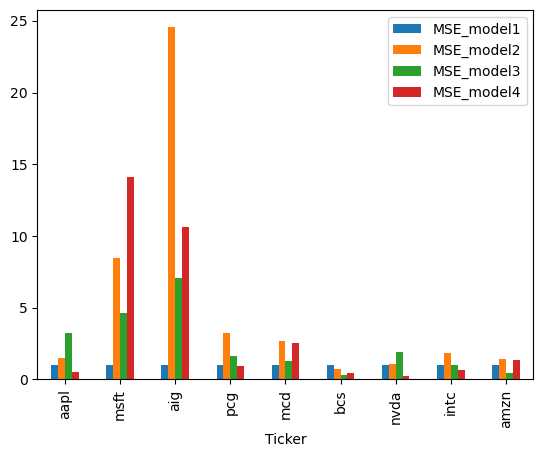

In [95]:
mse_merged.set_index('Ticker').plot(kind='bar')

MSE is not showing any clear signal as to what model is better. 5 stocks are in favor of model 4 (multivarite, LSTM ppfs model).Given that in many cases MSE is higher by a lot in comparison to model 1, model 1 is more favourable. Simplicity wins. But model 4 (multivariate version of LSTM) looks promising.